In [1]:
%load_ext autoreload
%autoreload 2

# general
import numpy as np
import pandas as pd
from spectral import open_image, envi
from sklearn.preprocessing import MinMaxScaler
import re

# spatial
import xarray as xa
import rasterio
import pyproj
import rioxarray
import xesmf as xe

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import joblib


from sklearn.metrics import r2_score
from scipy.stats import ks_2samp
from sklearn.decomposition import PCA
from statsmodels.multivariate.manova import MANOVA

# custom
from reflectance import spectrum_utils, file_ops, optimisation_pipeline, plotting, ml_utils

# Subset

In [2]:
subset_dir_fp = file_ops.DATA_DIR_FP / "prism_images/prm20160924t004832_corr_v1w2_subset_img"
corr_fp = subset_dir_fp / "prm20160924t004832_corr_v1w2_subset_img"
corr_fp_hdr = subset_dir_fp / "prm20160924t004832_corr_v1w2_subset_img.hdr"

validation_data = pd.read_csv(file_ops.DATA_DIR_FP / "CORAL_validation_data.csv")

hs_corrected_metadata = open_image(corr_fp_hdr)
print("corrected:", hs_corrected_metadata)
hs_corrected_data = open_image(corr_fp_hdr).load()

corrected: 	Data Source:   '/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/coralreflections/data/prism_images/prm20160924t004832_corr_v1w2_subset_img/prm20160924t004832_corr_v1w2_subset_img'
	# Rows:           1637
	# Samples:         715
	# Bands:           246
	Interleave:        BIL
	Quantization:  32 bits
	Data format:   float32


In [62]:
import geopandas as gpd
temp.rio.write_crs("EPSG:32756", inplace=True)
# transform X, Y columns of validation to "EPSG:32756"

data = {'latitude': validation_data.Y.values, 'longitude': validation_data.X.values}  # Replace with your data
df = pd.DataFrame(data)

# Create GeoDataFrame with WGS84 coordinates (EPSG:4326)
gdf = gpd.GeoDataFrame(
    df, 
    geometry=gpd.points_from_xy(df.longitude, df.latitude), 
    crs="EPSG:4326"  # Set initial CRS as WGS84
)

# Reproject to EPSG:32756
gdf = gdf.to_crs("EPSG:32756")

# Display the transformed coordinates
gdf[['geometry']]

geometry
0       POINT (-313393.369 8362119.919)
1       POINT (-313393.369 8362119.919)
2       POINT (-313393.369 8362119.919)
3       POINT (-313393.369 8362119.919)
4       POINT (-313393.369 8362119.919)
...                                 ...
1933  POINT (-1598780.399 10837583.101)
1934  POINT (-1598780.399 10837583.101)
1935  POINT (-1598733.738 10837619.535)
1936  POINT (-1598733.738 10837619.535)
1937  POINT (-1598733.738 10837619.535)

[1938 rows x 1 columns]

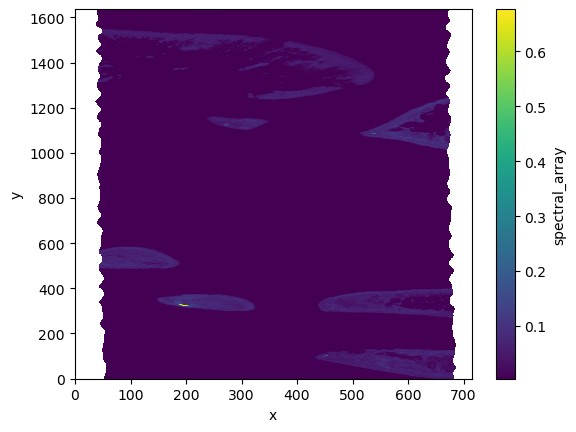

In [3]:
spatial_xy_xa = ml_utils.envi_to_xarray_with_latlon(corr_fp, hs_corrected_metadata.bands.centers)
spatial_xy_xa.name = "spectral_array"
# assign band values actual wavelength values

# visualise data
mean_scene_xa = spatial_xy_xa.median(dim="band", skipna=True)
mean_scene_xa.plot.imshow();

In [81]:
scene_lats = np.min(spatial_xy_xa.lat[:, 0]).values, np.max(spatial_xy_xa.lat[:, 0]).values
scene_lons = np.min(spatial_xy_xa.lon[0,:]).values, np.max(spatial_xy_xa.lon[0,:]).values

# select validation within scene
validation_within_scene = validation_data[
    (validation_data.X >= min(scene_lons)) & (validation_data.X <= max(scene_lons)) &
    (validation_data.Y >= min(scene_lats)) & (validation_data.Y <= max(scene_lats))
]
validation_within_scene

Empty DataFrame
Columns: [X, Y, Campaign, Locale, Station, TimeUTC, TimeLocal, Depth, Metabolism, Optics, Comments, algCCA, algCyano, algMacBrn, algMacGrn, algMacMix, algMacRed, algMacUnk, algTurf, crlCoral, crlBleach, othOcto, othSeagr, othClam, othInvert, othOther, othSponge, othUrchin, sedLimest, sedMud, sedRubble, sedSand, ROInumber, Flightline]
Index: []

[0 rows x 34 columns]

In [84]:
vals = np.ones((3, 3))

In [98]:
sources = ["prism", "planet", "s2"]
test_df = pd.DataFrame(vals, columns=["r2", "m", "c"], index=["algae", "coral", "sand"])

multiindex = pd.MultiIndex.from_tuples(
    [(source, metric) for source in sources for metric in ["r2", "m", "c"]],
    names=["source", "metric"]
)
multivals = np.concatenate([np.ones((3, 3)), np.ones((3, 3))*2, np.ones((3, 3))*3], axis=1)
combined_df = pd.DataFrame(multivals, columns=multiindex, index=["algae", "coral", "sand"])
combined_df

source prism           planet             s2          
metric    r2    m    c     r2    m    c   r2    m    c
algae    1.0  1.0  1.0    2.0  2.0  2.0  3.0  3.0  3.0
coral    1.0  1.0  1.0    2.0  2.0  2.0  3.0  3.0  3.0
sand     1.0  1.0  1.0    2.0  2.0  2.0  3.0  3.0  3.0

Text(0.5, 1.0, 'R^2 values for each source, per class')

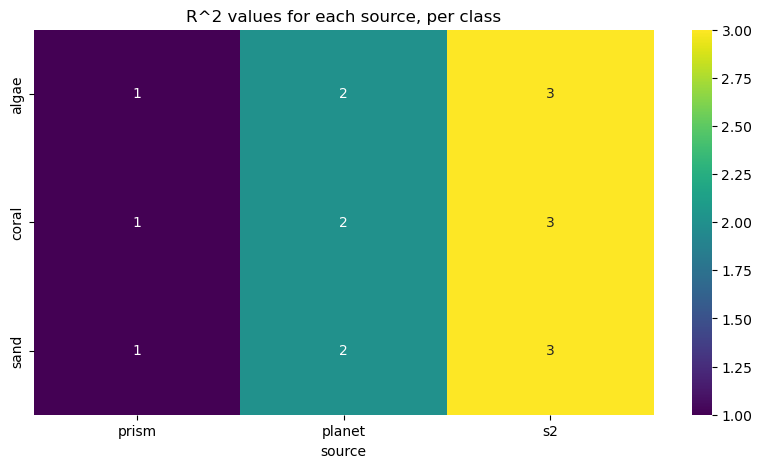

In [103]:
# plot r2, per (algae, coral, sand) for each source
fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(combined_df.xs("r2", level="metric", axis=1), annot=True, ax=ax, cmap="viridis")
ax.set_title("R^2 values for each source, per class")

In [102]:
combined_df.T.index.get_level_values("metric")

Index(['r2', 'm', 'c', 'r2', 'm', 'c', 'r2', 'm', 'c'], dtype='object', name='metric')

In [99]:
# Loop over each source to create a heatmap
for idx, source in enumerate(['prism', 'planet', 's2']):
    sns.heatmap(df[source], annot=True, cmap='coolwarm', cbar=True, ax=axs[idx])
    axs[idx].set_title(f'{source.capitalize()} Performance')
    axs[idx].set_xlabel('Metric')
    if idx == 0:
        axs[idx].set_ylabel('Type')
    else:
        axs[idx].set_ylabel('')

# Display the plot
plt.tight_layout()
plt.show()

KeyError: 'prism'

<Axes: xlabel='None'>

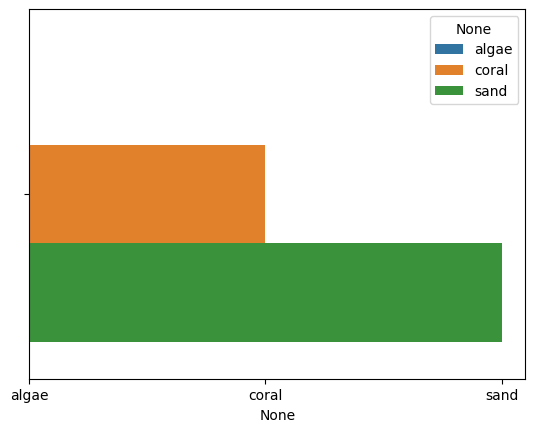

In [97]:
# plot side-by side bars: for each source, plot r2, m, c for each class

sns.barplot(data=combined_df, x=combined_df.index, hue=combined_df.index)

In [19]:
spectra_vals = spatial_xy_xa.values.reshape(spatial_xy_xa.shape[0], -1)
# drop NaNs
spectra_df = pd.DataFrame(spectra_vals.T, columns = spatial_xy_xa.band.values)
spectra_df_no_nans= spectra_df.dropna(axis=0)
spectra_df_no_nans

350.72    353.55    356.38    359.21    362.04    364.87    367.70   \
53       0.031886  0.045100  0.128817  0.122616  0.127028  0.112125  0.097626   
54       0.031886  0.045100  0.128817  0.122616  0.127028  0.112125  0.097626   
55       0.041807  0.036914  0.122026  0.111169  0.123595  0.110734  0.093505   
56       0.024053  0.037343  0.114354  0.114700  0.117179  0.104843  0.098965   
57       0.001044  0.021794  0.109831  0.109146  0.109758  0.105312  0.093486   
...           ...       ...       ...       ...       ...       ...       ...   
1170411 -0.037986 -0.023495  0.051730  0.058812  0.065378  0.063668  0.053405   
1170412 -0.034885 -0.010652  0.054877  0.059077  0.072892  0.062221  0.053839   
1170413 -0.029141 -0.011029  0.065765  0.068335  0.070419  0.066938  0.055389   
1170414 -0.017094 -0.012076  0.058144  0.064665  0.075288  0.067728  0.059176   
1170415 -0.022205 -0.010633  0.068300  0.071210  0.074804  0.067424  0.060186   

          370.53    373.36    376.19   ...   1020.22   1023.06   1025.91  \
53       0.088065  0.077233  0.078323  ...  0.003129  0.003366  0.003621   
54       0.088065  0.077233  0.078323  ...  0.003129  0.003366  0.003621   
55       0.090951  0.079586  0.075957  ...  0.002730  0.004134  0.003037   
56       0.088834  0.075923  0.077173  ...  0.003193  0.003673  0.002618   
57       0.085893  0.075120  0.075443  ...  0.003214  0.003106  0.003166   
...           ...       ...       ...  ...       ...       ...       ...   
1170411  0.054555  0.047049  0.049478  ...  0.002852  0.002549  0.002805   
1170412  0.055659  0.045978  0.050846  ...  0.002651  0.003090  0.003083   
1170413  0.051541  0.045589  0.052419  ...  0.002667  0.002761  0.002806   
1170414  0.059805  0.047878  0.053576  ...  0.002837  0.002650  0.002924   
1170415  0.057058  0.051475  0.050851  ...  0.003118  0.002939  0.002743   

          1028.75   1031.59   1034.44   1037.28   1040.12   1042.97   1045.81  
53       0.002999  0.003225  0.002910  0.003721  0.003754  0.003385  0.003527  
54       0.002999  0.003225  0.002910  0.003721  0.003754  0.003385  0.003527  
55       0.003659  0.003487  0.003708  0.003205  0.003955  0.003168  0.002752  
56       0.003735  0.003607  0.003647  0.003560  0.002622  0.003003  0.003198  
57       0.003247  0.003008  0.003671  0.003122  0.002577  0.003448  0.003771  
...           ...       ...       ...       ...       ...       ...       ...  
1170411  0.002855  0.002572  0.003227  0.002363  0.002982  0.003840  0.002885  
1170412  0.002553  0.003330  0.002799  0.002670  0.002943  0.002759  0.003090  
1170413  0.002558  0.002630  0.002857  0.003122  0.003420  0.002785  0.002969  
1170414  0.002887  0.003053  0.002448  0.002541  0.002301  0.002650  0.002399  
1170415  0.002954  0.002599  0.003155  0.002873  0.002476  0.002855  0.002253  

[1031624 rows x 246 columns]

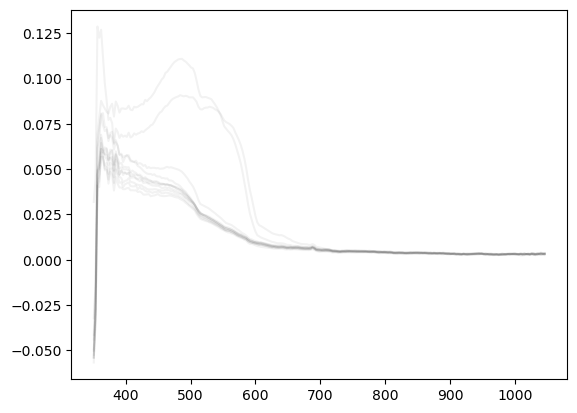

In [25]:
plt.plot(spectra_df_no_nans.iloc[::100000].T, c="k", alpha=0.05);

In [26]:
spatial_xy_xa

<xarray.DataArray 'spectral_array' (band: 246, y: 1637, x: 715)> Size: 1GB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
    lat      (y, x) float64 9MB -21.95 -21.95 -21.95 ... -22.04 -22.04 -22.04
    lon      (y, x) float64 9MB 152.5 152.5 152.5 152.5 ... 152.6 152.6 152.6
  * band     (band) float64 2kB 350.7 353.6 356.4 ... 1.043e+03 1.046e+03
Dimensions without coordinates: y, x
Attributes:
    driver:     ENVI
    dtype:      float32
    nodata:     -9999.0
    width:      715
    height:     1637
    count:      246
    crs:        EPSG:32756
    transform:  | 7.28, 2.80, 453094.67|\n| 2.80,-7.28, 7572735.99|\n| 0.00, ...

In [42]:
sample = spatial_xy_xa.isel(x=slice(0,100), y=slice(0,100))
sample.rio.write_crs("EPSG:32756", inplace=True)
sample.rio.reproject("EPSG:4326")

/Users/rt582/miniforge3/envs/spectra/lib/python3.12/site-packages/rioxarray/rioxarray.py:692: UserWarning: Transform that is non-rectilinear or with rotation found. Unable to recalculate.
  warnings.warn(


ValueError: conflicting sizes for dimension 'y': length 97 on the data but length 100 on coordinate 'lon'

In [63]:
regridded = ml_utils.regrid_with_xesmf(spatial_xy_xa)

/Users/rt582/miniforge3/envs/spectra/lib/python3.12/site-packages/rioxarray/rioxarray.py:692: UserWarning: Transform that is non-rectilinear or with rotation found. Unable to recalculate.
  warnings.warn(


In [36]:
out

<xarray.DataArray (band: 246, lat: 100, lon: 100)> Size: 10MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * band         (band) float64 2kB 350.7 353.6 356.4 ... 1.043e+03 1.046e+03
  * lat          (lat) float64 800B -21.96 -21.96 -21.96 ... -21.95 -21.95
  * lon          (lon) float64 800B 152.5 152.5 152.5 ... 152.6 152.6 152.6
    spatial_ref  int64 8B 0
Attributes:
    driver:      ENVI
    dtype:       float32
    width:       715
    height:      1637
    count:       246
    _FillValue:  -9999.0

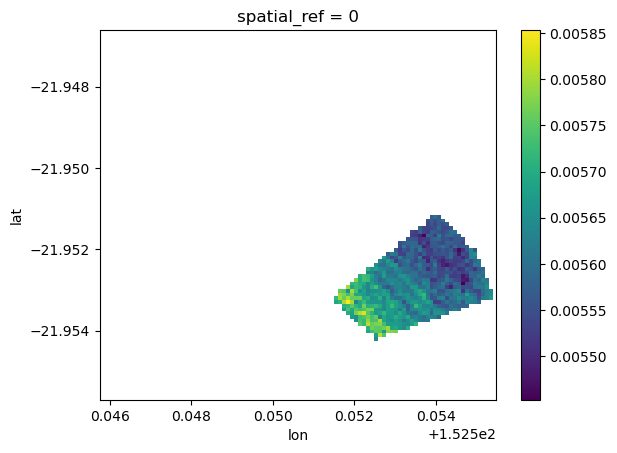

In [37]:
out.median(dim="band").plot.imshow()

In [ ]:
scene_xa = ml_utils.regrid_with_xesmf(spatial_xy_xa)


/Users/rt582/miniforge3/envs/spectra/lib/python3.12/site-packages/rioxarray/rioxarray.py:692: UserWarning: Transform that is non-rectilinear or with rotation found. Unable to recalculate.
  warnings.warn(


In [ ]:
scene_xa

In [ ]:
masked_scene_vals = scene_xa.values.reshape(scene_xa.sizes["band"], -1)

wvs = hs_corrected_metadata.bands.centers
hs_vals = pd.DataFrame(masked_scene_vals.T, columns=wvs)
# process: deglint and crop to sensor range
hs_vals = spectrum_utils.deglint_spectra(hs_vals)
hs_vals = spectrum_utils.crop_spectra_to_range(hs_vals)
# plot, taking band values as RGB values
vis_percentiles=(0.1, 99.9)
rgb_vals = plotting.generate_and_visualise_spectral_colours(hs_vals, vis_percentiles=vis_percentiles)


fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={"projection": ccrs.PlateCarree()},dpi=300)
# reform rgb_vals back to scene_xa dataset
rgb_xa = xa.DataArray(rgb_vals.reshape(len(scene_xa.lat), len(scene_xa.lon), -1), dims=("lat", "lon", "rgb"), coords={"lat": scene_xa.lat, "lon": scene_xa.lon, "rgb": ["r", "g", "b"]})
rgb_xa.plot.imshow(rgb="rgb", ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False);

fig.patch.set_alpha(0)
ax.patch.set_alpha(0)
ax.grid(True, color="white", alpha=0.5, linestyle="--")
plotting.format_axis_for_ppt(ax);

In [2]:
corr_fp = file_ops.DATA_DIR_FP / "prism_images" / "prism_kbay_corr_ss.img"
corr_fp_hdr = file_ops.DATA_DIR_FP / "prism_images" / "prism_kbay_corr_ss.img.hdr"
mask_fp = file_ops.DATA_DIR_FP / "prism_images" / "prism_kbay_mask_ss.img"
mask_fp_hdr = file_ops.DATA_DIR_FP / "prism_images" / "prism_kbay_mask_ss.img.hdr"

validation_data = pd.read_csv(file_ops.DATA_DIR_FP / "CORAL_validation_data.csv")

hs_mask_metadata = open_image(mask_fp_hdr)
hs_corrected_metadata = open_image(corr_fp_hdr)
print("masked:", hs_mask_metadata)
print("corrected:", hs_corrected_metadata)
hs_corrected_data = open_image(corr_fp_hdr).load()

masked: 	Data Source:   '/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/coralreflections/data/prism_images/prism_kbay_mask_ss.img'
	# Rows:           1045
	# Samples:         863
	# Bands:             1
	Interleave:        BSQ
	Quantization:   8 bits
	Data format:     uint8
corrected: 	Data Source:   '/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/coralreflections/data/prism_images/prism_kbay_corr_ss.img'
	# Rows:           1045
	# Samples:         863
	# Bands:           246
	Interleave:        BSQ
	Quantization:  32 bits
	Data format:   float32


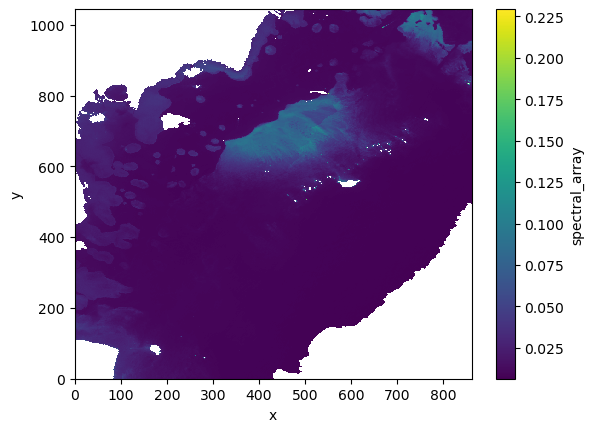

In [3]:
spatial_xy_xa = ml_utils.envi_to_xarray_with_latlon(corr_fp)
mask_xa = ml_utils.envi_to_xarray_with_latlon(mask_fp)
# broadcast mask_xa to have same number of bands as scene_xa
mask_xa = mask_xa.broadcast_like(spatial_xy_xa)
mask_xa.values = np.broadcast_to(mask_xa.values[0], mask_xa.shape)
masked_scene_xa = spatial_xy_xa.where(mask_xa == 1, np.nan)
masked_scene_xa.name = "spectral_array"
# assign band values actual wavelength values
masked_scene_xa.coords["band"] = hs_corrected_metadata.bands.centers

# visualise data
mean_scene_xa = masked_scene_xa.median(dim="band", skipna=True)
mean_scene_xa.plot.imshow();

In [4]:
scene_xa = ml_utils.regrid_with_xesmf(masked_scene_xa)
scene_xa.name = "site"

In [5]:
# take 5 pca components of the array
pca = PCA(n_components=5)
df = ml_utils.spectral_xa_to_processed_spectral_df(scene_xa)
df_pca = ml_utils.process_df_for_inference(df)


Doing PCA...


In [6]:
# get shape of xarray dataset
scene_xa.shape

(246, 1045, 863)

In [7]:
pca_xa = ml_utils.reform_spatial_from_df(df_pca, df.index, scene_xa, "pc_components")

/Users/rt582/miniforge3/envs/spectra/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


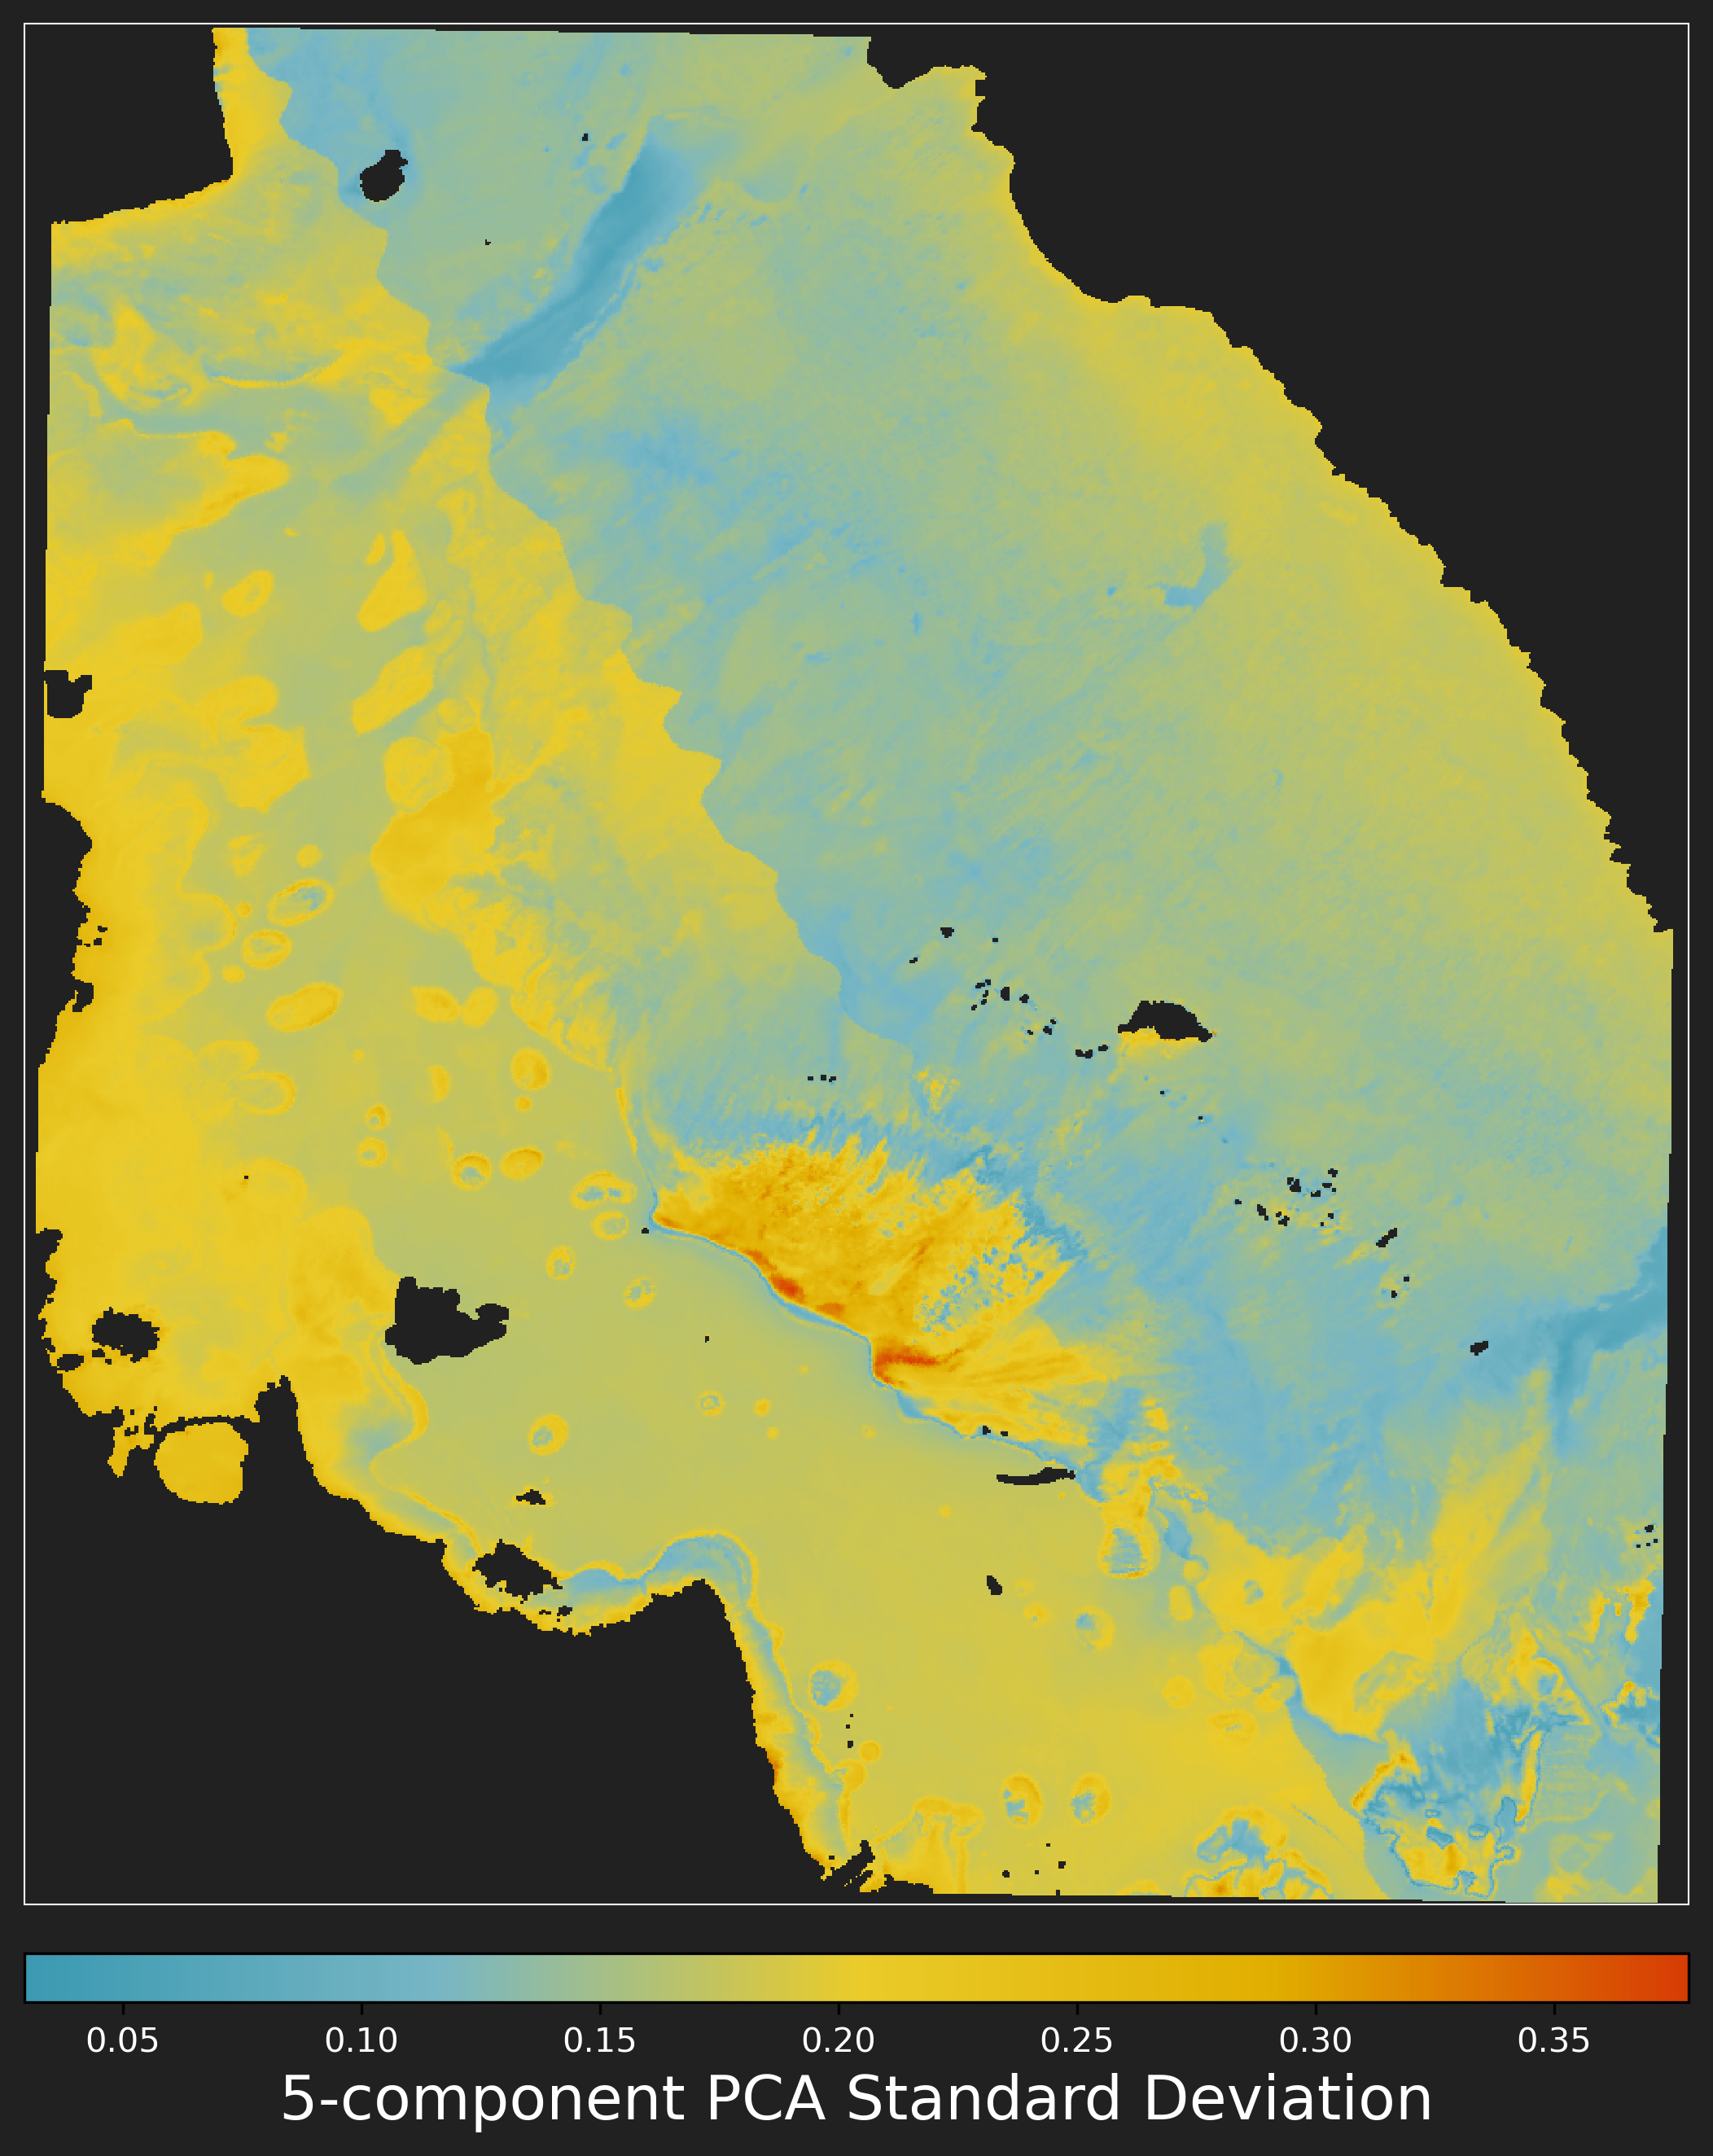

In [8]:
plotting.plot_spatial(pca_xa.std(dim="pc_components"), title="", presentation_format=True, cartopy_dict={"alpha": 0, "labels": False}, labels=False, cbar_dict={"cbar_pad": 1, "cbar_name": "5-component PCA Standard Deviation", "orientation": "horizontal", "fontsize": 18});


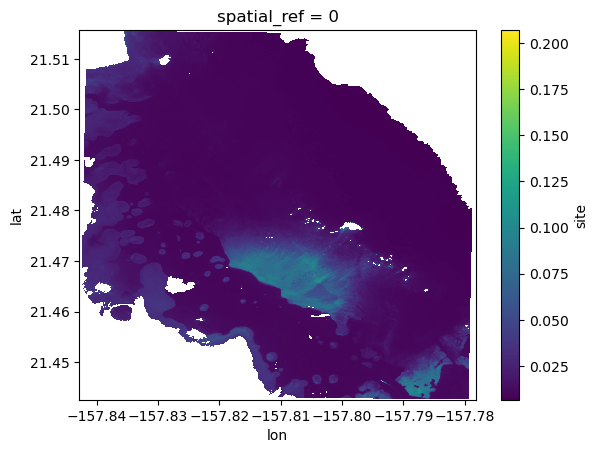

In [9]:
scene_xa.median(dim="band", skipna=True).plot()

In [10]:
masked_scene_vals = scene_xa.values.reshape(scene_xa.sizes["band"], -1)

wvs = hs_corrected_metadata.bands.centers
hs_vals = pd.DataFrame(masked_scene_vals.T, columns=wvs)
# process: deglint and crop to sensor range
hs_vals = spectrum_utils.deglint_spectra(hs_vals)
hs_vals = spectrum_utils.crop_spectra_to_range(hs_vals)

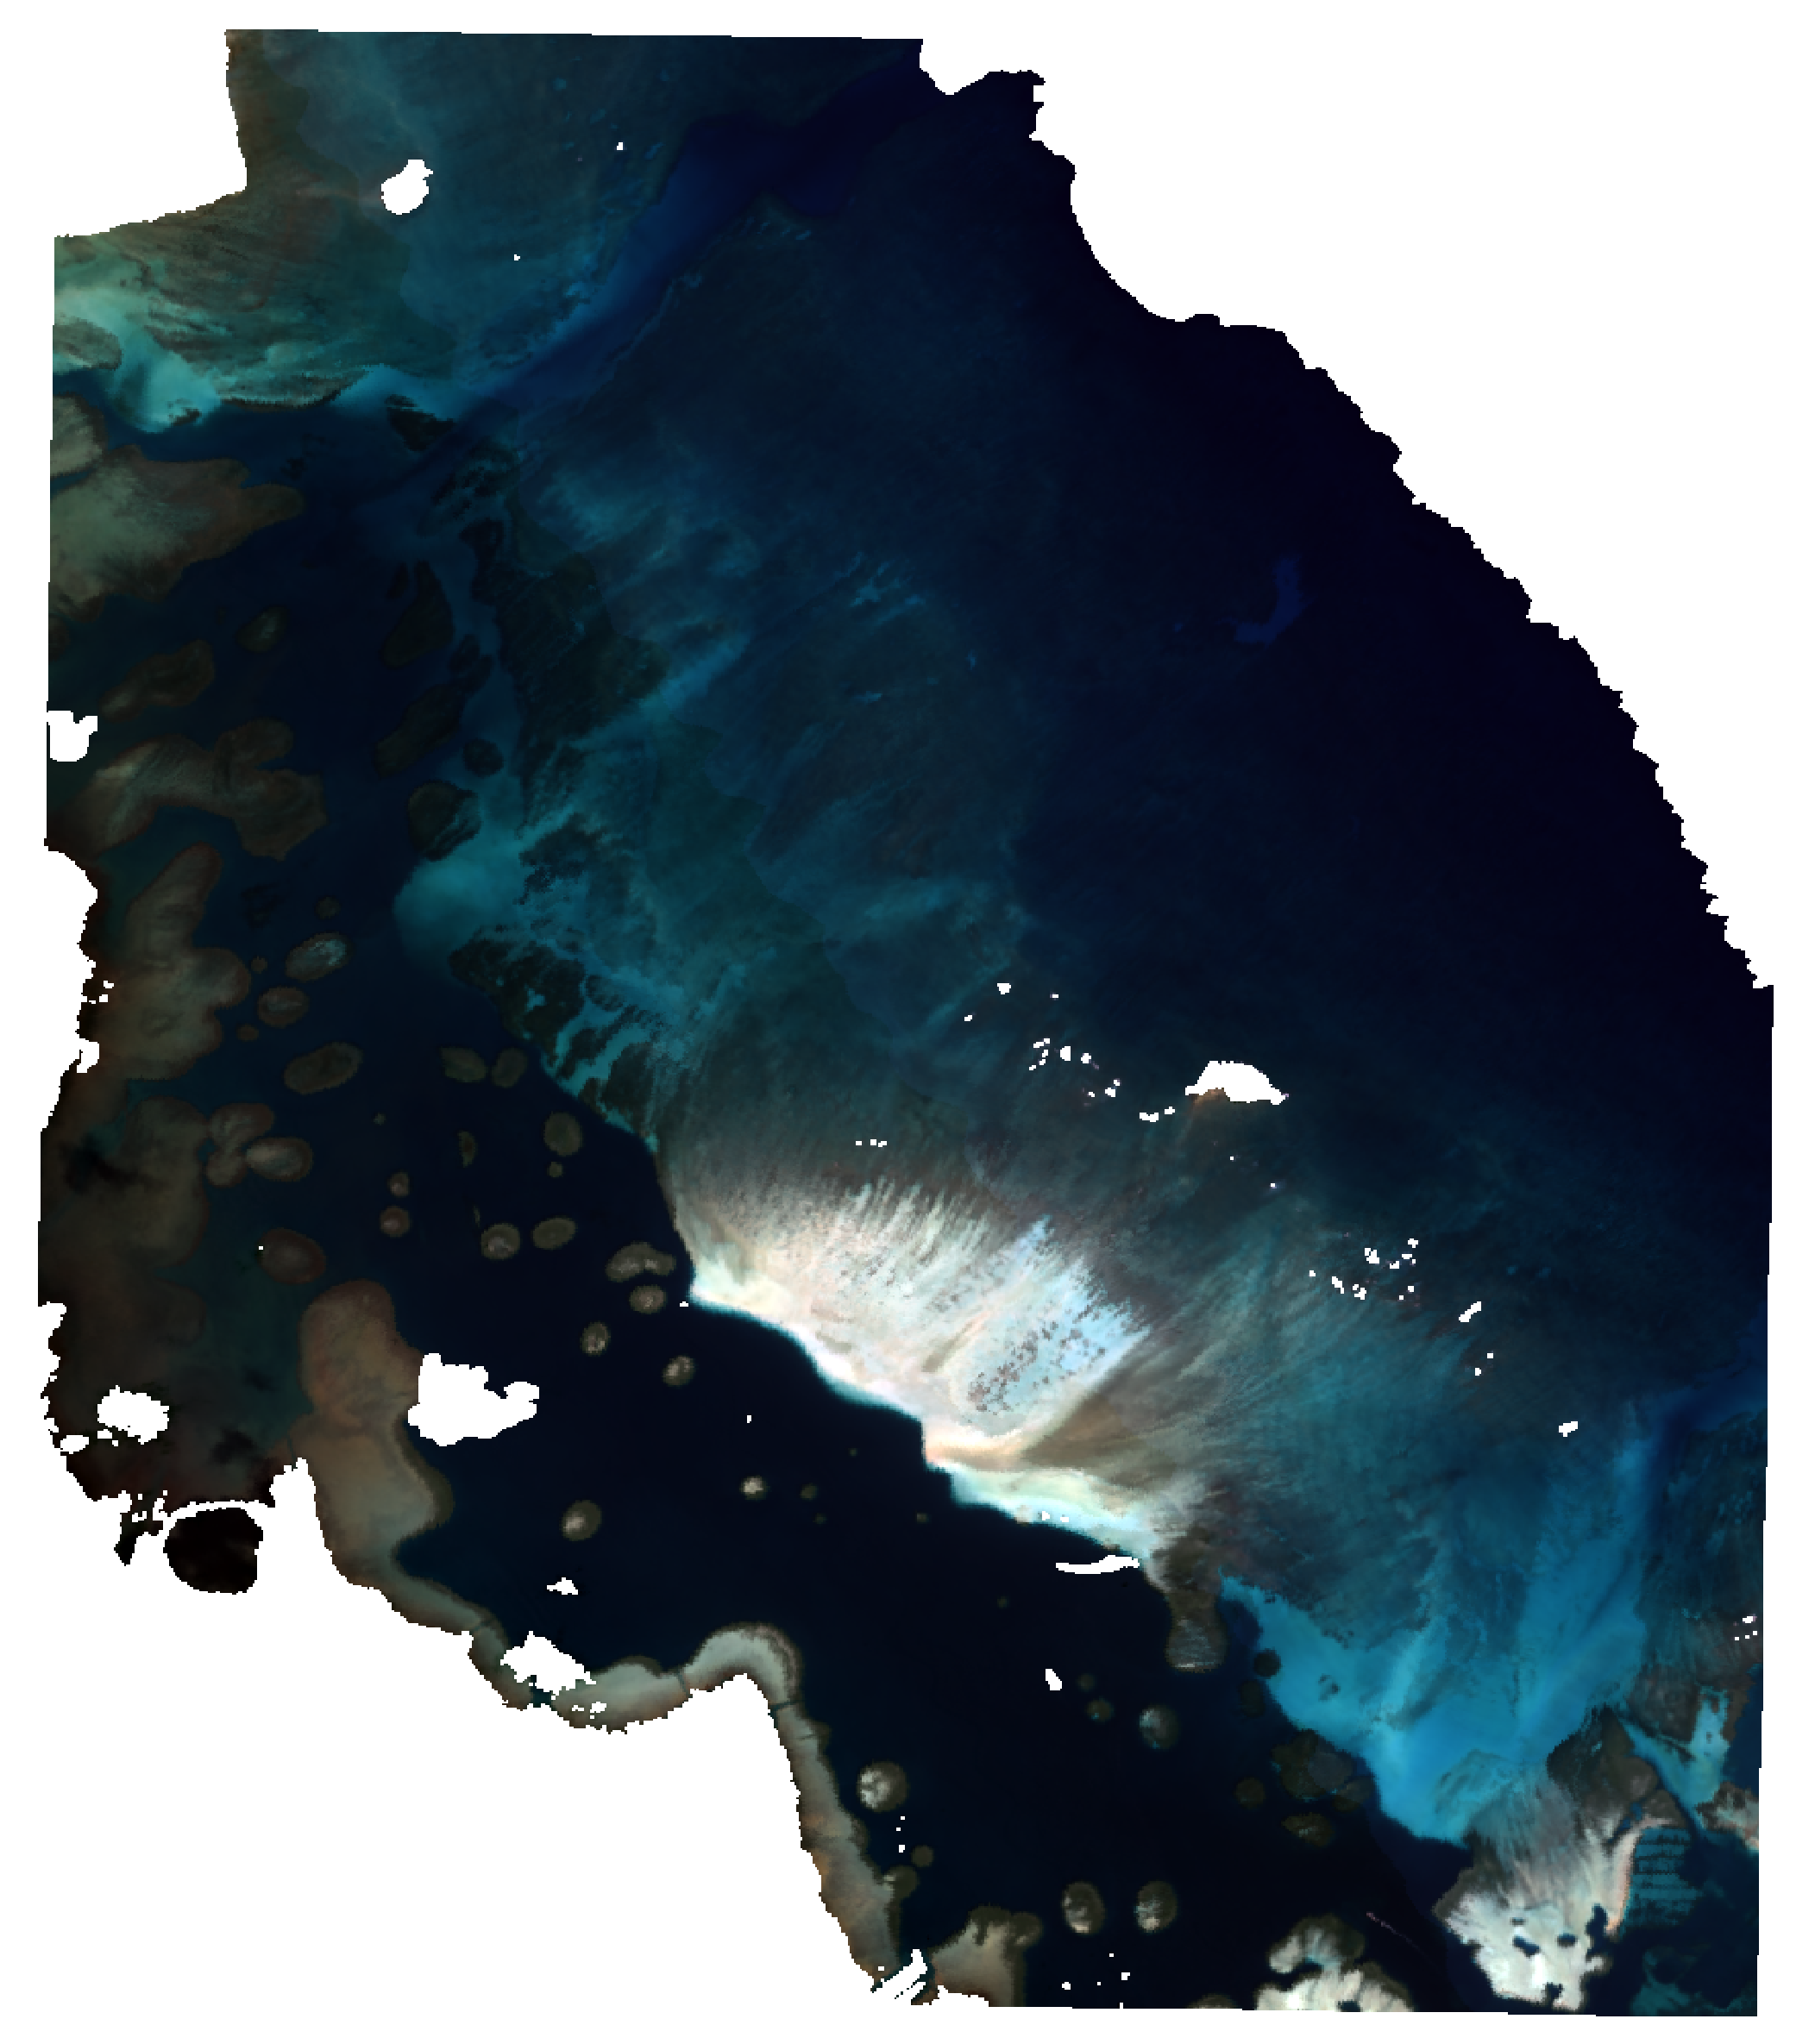

In [27]:

# plot, taking band values as RGB values
vis_percentiles=(0.1, 99.9)
rgb_vals = plotting.generate_and_visualise_spectral_colours(hs_vals, vis_percentiles=vis_percentiles)


fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={"projection": ccrs.PlateCarree()},dpi=300)
# reform rgb_vals back to scene_xa dataset
rgb_xa = xa.DataArray(rgb_vals.reshape(len(scene_xa.lat), len(scene_xa.lon), -1), dims=("lat", "lon", "rgb"), coords={"lat": scene_xa.lat, "lon": scene_xa.lon, "rgb": ["r", "g", "b"]})
rgb_xa.plot.imshow(rgb="rgb", ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False);

fig.patch.set_alpha(0)
ax.patch.set_alpha(0)
ax.grid(True, color="white", alpha=0.5, linestyle="--")
plotting.format_axis_for_ppt(ax);

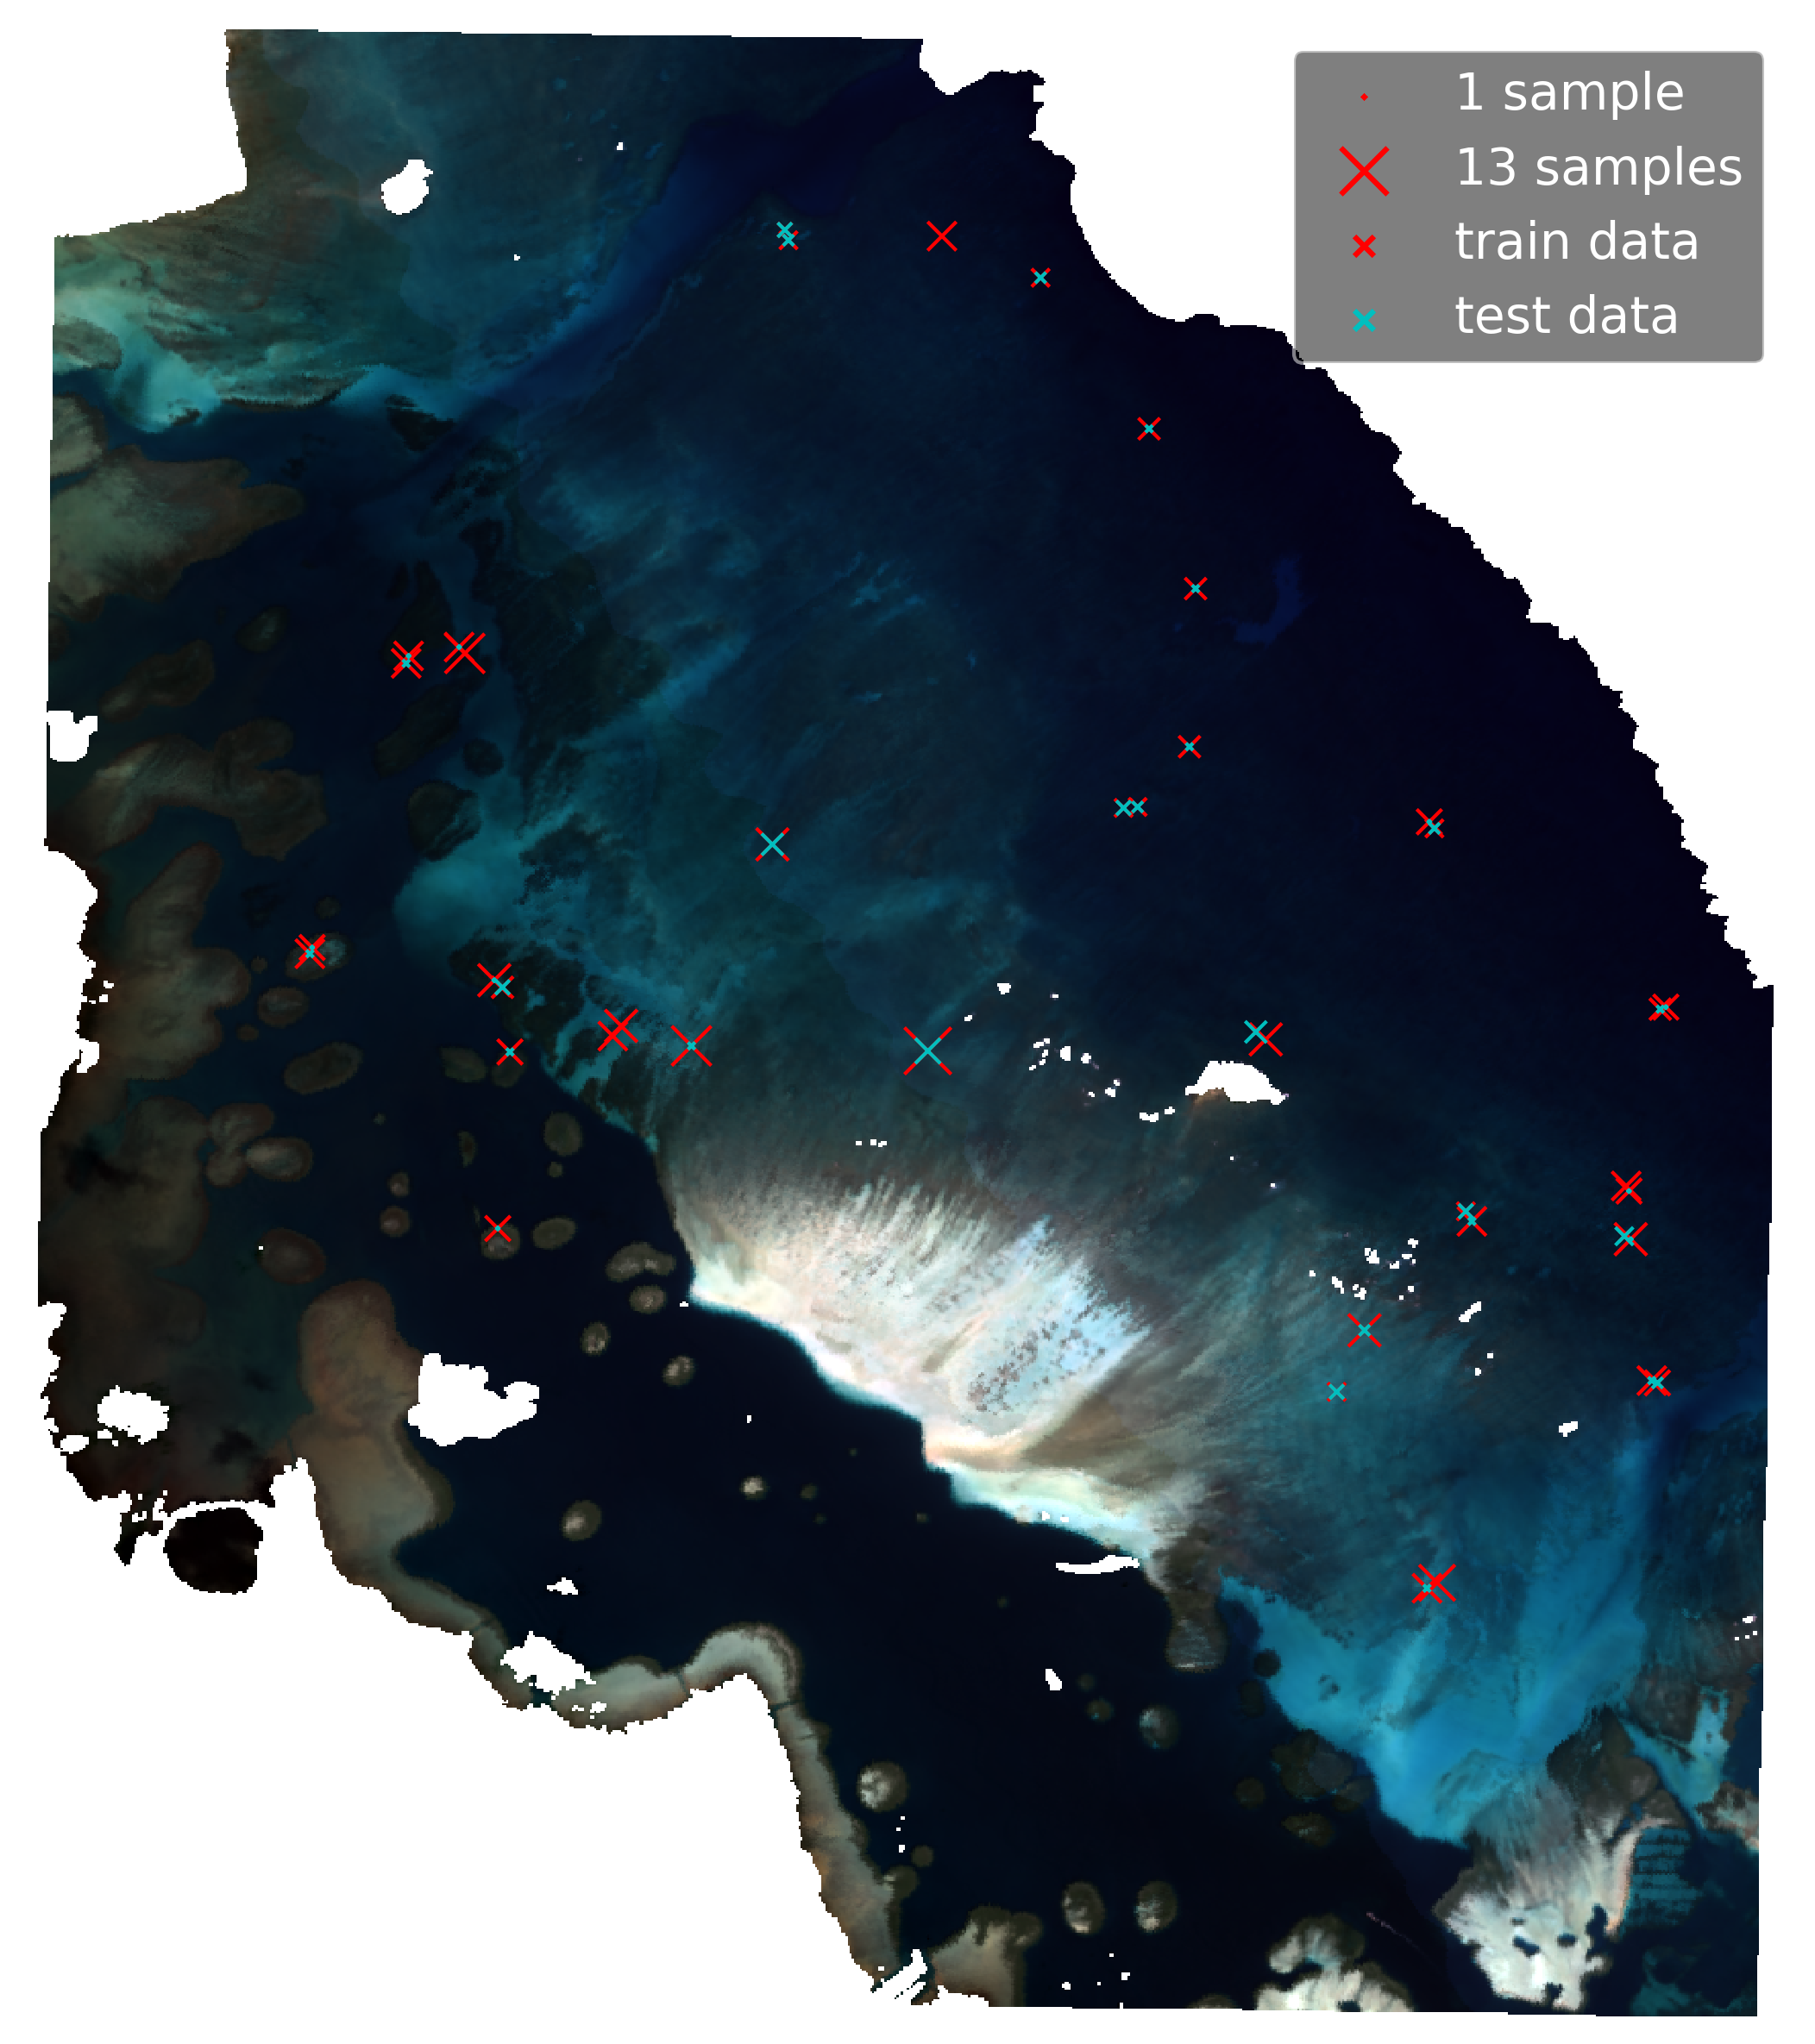

In [62]:
# plot, taking band values as RGB values
vis_percentiles=(0.1, 99.9)
rgb_vals = plotting.generate_and_visualise_spectral_colours(hs_vals, vis_percentiles=vis_percentiles)


fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={"projection": ccrs.PlateCarree()},dpi=300)
# reform rgb_vals back to scene_xa dataset
rgb_xa = xa.DataArray(rgb_vals.reshape(len(scene_xa.lat), len(scene_xa.lon), -1), dims=("lat", "lon", "rgb"), coords={"lat": scene_xa.lat, "lon": scene_xa.lon, "rgb": ["r", "g", "b"]})
rgb_xa.plot.imshow(rgb="rgb", ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False);

fig.patch.set_alpha(0)
ax.patch.set_alpha(0)
ax.grid(True, color="white", alpha=0.5, linestyle="--")

ax.scatter(train_sample_counts.X, train_sample_counts.Y, s=train_sample_counts.counts ** 2, color="red", marker="x", lw=1, alpha=1)
ax.scatter(test_sample_counts.X, test_sample_counts.Y, s=test_sample_counts.counts ** 2, color="c", marker="x", lw=1, alpha=1)
ax.scatter([],[], marker="x", s=min(min(train_sample_counts.counts), min(test_sample_counts.counts)) ** 2, color="red", label=f"{min(min(train_sample_counts.counts), min(test_sample_counts.counts))} sample")
ax.scatter([],[], marker="x", s=max(max(train_sample_counts.counts), max(test_sample_counts.counts)) ** 2, color="red", label=f"{max(max(train_sample_counts.counts), max(test_sample_counts.counts))} samples")
ax.scatter([],[], marker="x", s=30, color="red", label="train data")
ax.scatter([],[], marker="x", s=30, color="c", label="test data")

ax.legend(facecolor="black", framealpha=0.5, edgecolor="white", labelcolor="white", fontsize=14)
plotting.format_axis_for_ppt(ax);

In [13]:
# save scene_xa to disk
scene_xa.to_netcdf(file_ops.TMP_DIR_FP / "kaneohe_hs_masked.nc")

## Comparison with validation

In [39]:
print("validation sites:", validation_data.Locale.unique())
(X_train, X_test), (y1,y2), depth_labels = ml_utils.MLDataPipe(
    endmember_class_schema="three_endmember", target="depth", data_source="prism_fits").generate_data()
depth_labels = depth_labels[~depth_labels.index.duplicated(keep='first')]
kbay_indices = validation_data[validation_data.Locale == "Kaneohe Bay"].index

validation sites: ['Lizard Island' 'Heron Island' 'Lanai' 'Maui' 'Hawaii' 'Kaneohe Bay'
 'Palau']


In [40]:
print("validation sites:", validation_data.Locale.unique())
(X_train, X_test), (y1,y2), benthic_labels = ml_utils.MLDataPipe(
    endmember_class_schema="three_endmember", target="endmember", data_source="prism_fits").generate_data()
benthic_labels = benthic_labels[~benthic_labels.index.duplicated(keep='first')]
kbay_indices = validation_data[validation_data.Locale == "Kaneohe Bay"].index

validation sites: ['Lizard Island' 'Heron Island' 'Lanai' 'Maui' 'Hawaii' 'Kaneohe Bay'
 'Palau']


In [41]:
# get indices of validation data in Kaneohe Bay
kbay_validation = validation_data.loc[kbay_indices]
# join labels to validation data
kbay_labels = depth_labels.loc[kbay_indices.intersection(depth_labels.index)]
kbay_benthic_labels = benthic_labels.loc[kbay_indices.intersection(benthic_labels.index)]
# kbay_validation = kbay_validation.join(kbay_labels)

extent = (kbay_validation.X >= rgb_xa.lon.values.min()) & (kbay_validation.X <= rgb_xa.lon.values.max()) & (kbay_validation.Y >= rgb_xa.lat.values.min()) & (kbay_validation.Y <= rgb_xa.lat.values.max())
kbay_validation.loc[extent]

X          Y Campaign       Locale  Station        TimeUTC  \
1151 -157.825553  21.471535   Hawaii  Kaneohe Bay      609  2/15/17 19:45   
1152 -157.825553  21.471535   Hawaii  Kaneohe Bay      609  2/15/17 19:45   
1153 -157.825553  21.471535   Hawaii  Kaneohe Bay      609  2/15/17 19:45   
1154 -157.825553  21.471535   Hawaii  Kaneohe Bay      609  2/15/17 19:45   
1155 -157.828916  21.492282   Hawaii  Kaneohe Bay      618  2/16/17 22:04   
...          ...        ...      ...          ...      ...            ...   
1559 -157.815017  21.508195   Hawaii  Kaneohe Bay      619  2/16/17 23:44   
1560 -157.814883  21.507816   Hawaii  Kaneohe Bay      620   2/17/17 0:10   
1561 -157.814883  21.507816   Hawaii  Kaneohe Bay      620   2/17/17 0:10   
1562 -157.814883  21.507816   Hawaii  Kaneohe Bay      620   2/17/17 0:10   
1563 -157.814883  21.507816   Hawaii  Kaneohe Bay      620   2/17/17 0:10   

          TimeLocal  Depth Metabolism Optics  ... othInvert  othOther  \
1151   2/15/17 8:45    5.5        NaN    NaN  ...         0         0   
1152   2/15/17 8:45    5.5        NaN    NaN  ...         0         0   
1153   2/15/17 8:45    5.5        NaN    NaN  ...         0         0   
1154   2/15/17 8:45    5.5        NaN    NaN  ...         0         0   
1155  2/16/17 11:04    4.9        NaN    NaN  ...         0         0   
...             ...    ...        ...    ...  ...       ...       ...   
1559  2/16/17 12:44    4.3        NaN    NaN  ...         0         0   
1560  2/16/17 13:10    5.2        NaN    NaN  ...         0         0   
1561  2/16/17 13:10    5.2        NaN    NaN  ...         0         0   
1562  2/16/17 13:10    5.2        NaN    NaN  ...         0         0   
1563  2/16/17 13:10    5.2        NaN    NaN  ...         0         0   

      othSponge  othUrchin  sedLimest  sedMud  sedRubble  sedSand  ROInumber  \
1151          0          0          0       0          0        4        199   
1152          0          0          0       0          0        4        199   
1153          0          0          0       0          0        4        199   
1154          0          0          0       0          0        4        199   
1155          0          0          0       0          0        9        200   
...         ...        ...        ...     ...        ...      ...        ...   
1559          0          0          0       0          0        3        287   
1560          0          0          0       0          0        2        288   
1561          0          0          0       0          0        2        288   
1562          0          0          0       0          0        2        288   
1563          0          0          0       0          0        2        288   

                            Flightline  
1151  prm20170306t194614_corr_v1w3_img  
1152  prm20170306t194614_corr_v1w3_img  
1153  prm20170306t194614_corr_v1w3_img  
1154  prm20170306t194614_corr_v1w3_img  
1155  prm20170306t194614_corr_v1w3_img  
...                                ...  
1559  prm20170306t202626_corr_v1w3_img  
1560  prm20170306t202626_corr_v1w3_img  
1561  prm20170306t202626_corr_v1w3_img  
1562  prm20170306t202626_corr_v1w3_img  
1563  prm20170306t202626_corr_v1w3_img  

[395 rows x 34 columns]

In [43]:
kbay_X_train = X_train.loc[X_train.index.intersection(kbay_indices)].loc[extent]
kbay_X_train=kbay_X_train[~kbay_X_train.index.duplicated(keep='first')]
kbay_train_inds=kbay_X_train.index
kbay_X_test = X_test.loc[X_test.index.intersection(kbay_indices)].loc[extent]
kbay_X_test=kbay_X_test[~kbay_X_test.index.duplicated(keep='first')]
kbay_test_inds=kbay_X_test.index

In [44]:
kbay_train_meta = kbay_validation.loc[kbay_train_inds]
kbay_test_meta = kbay_validation.loc[kbay_test_inds]

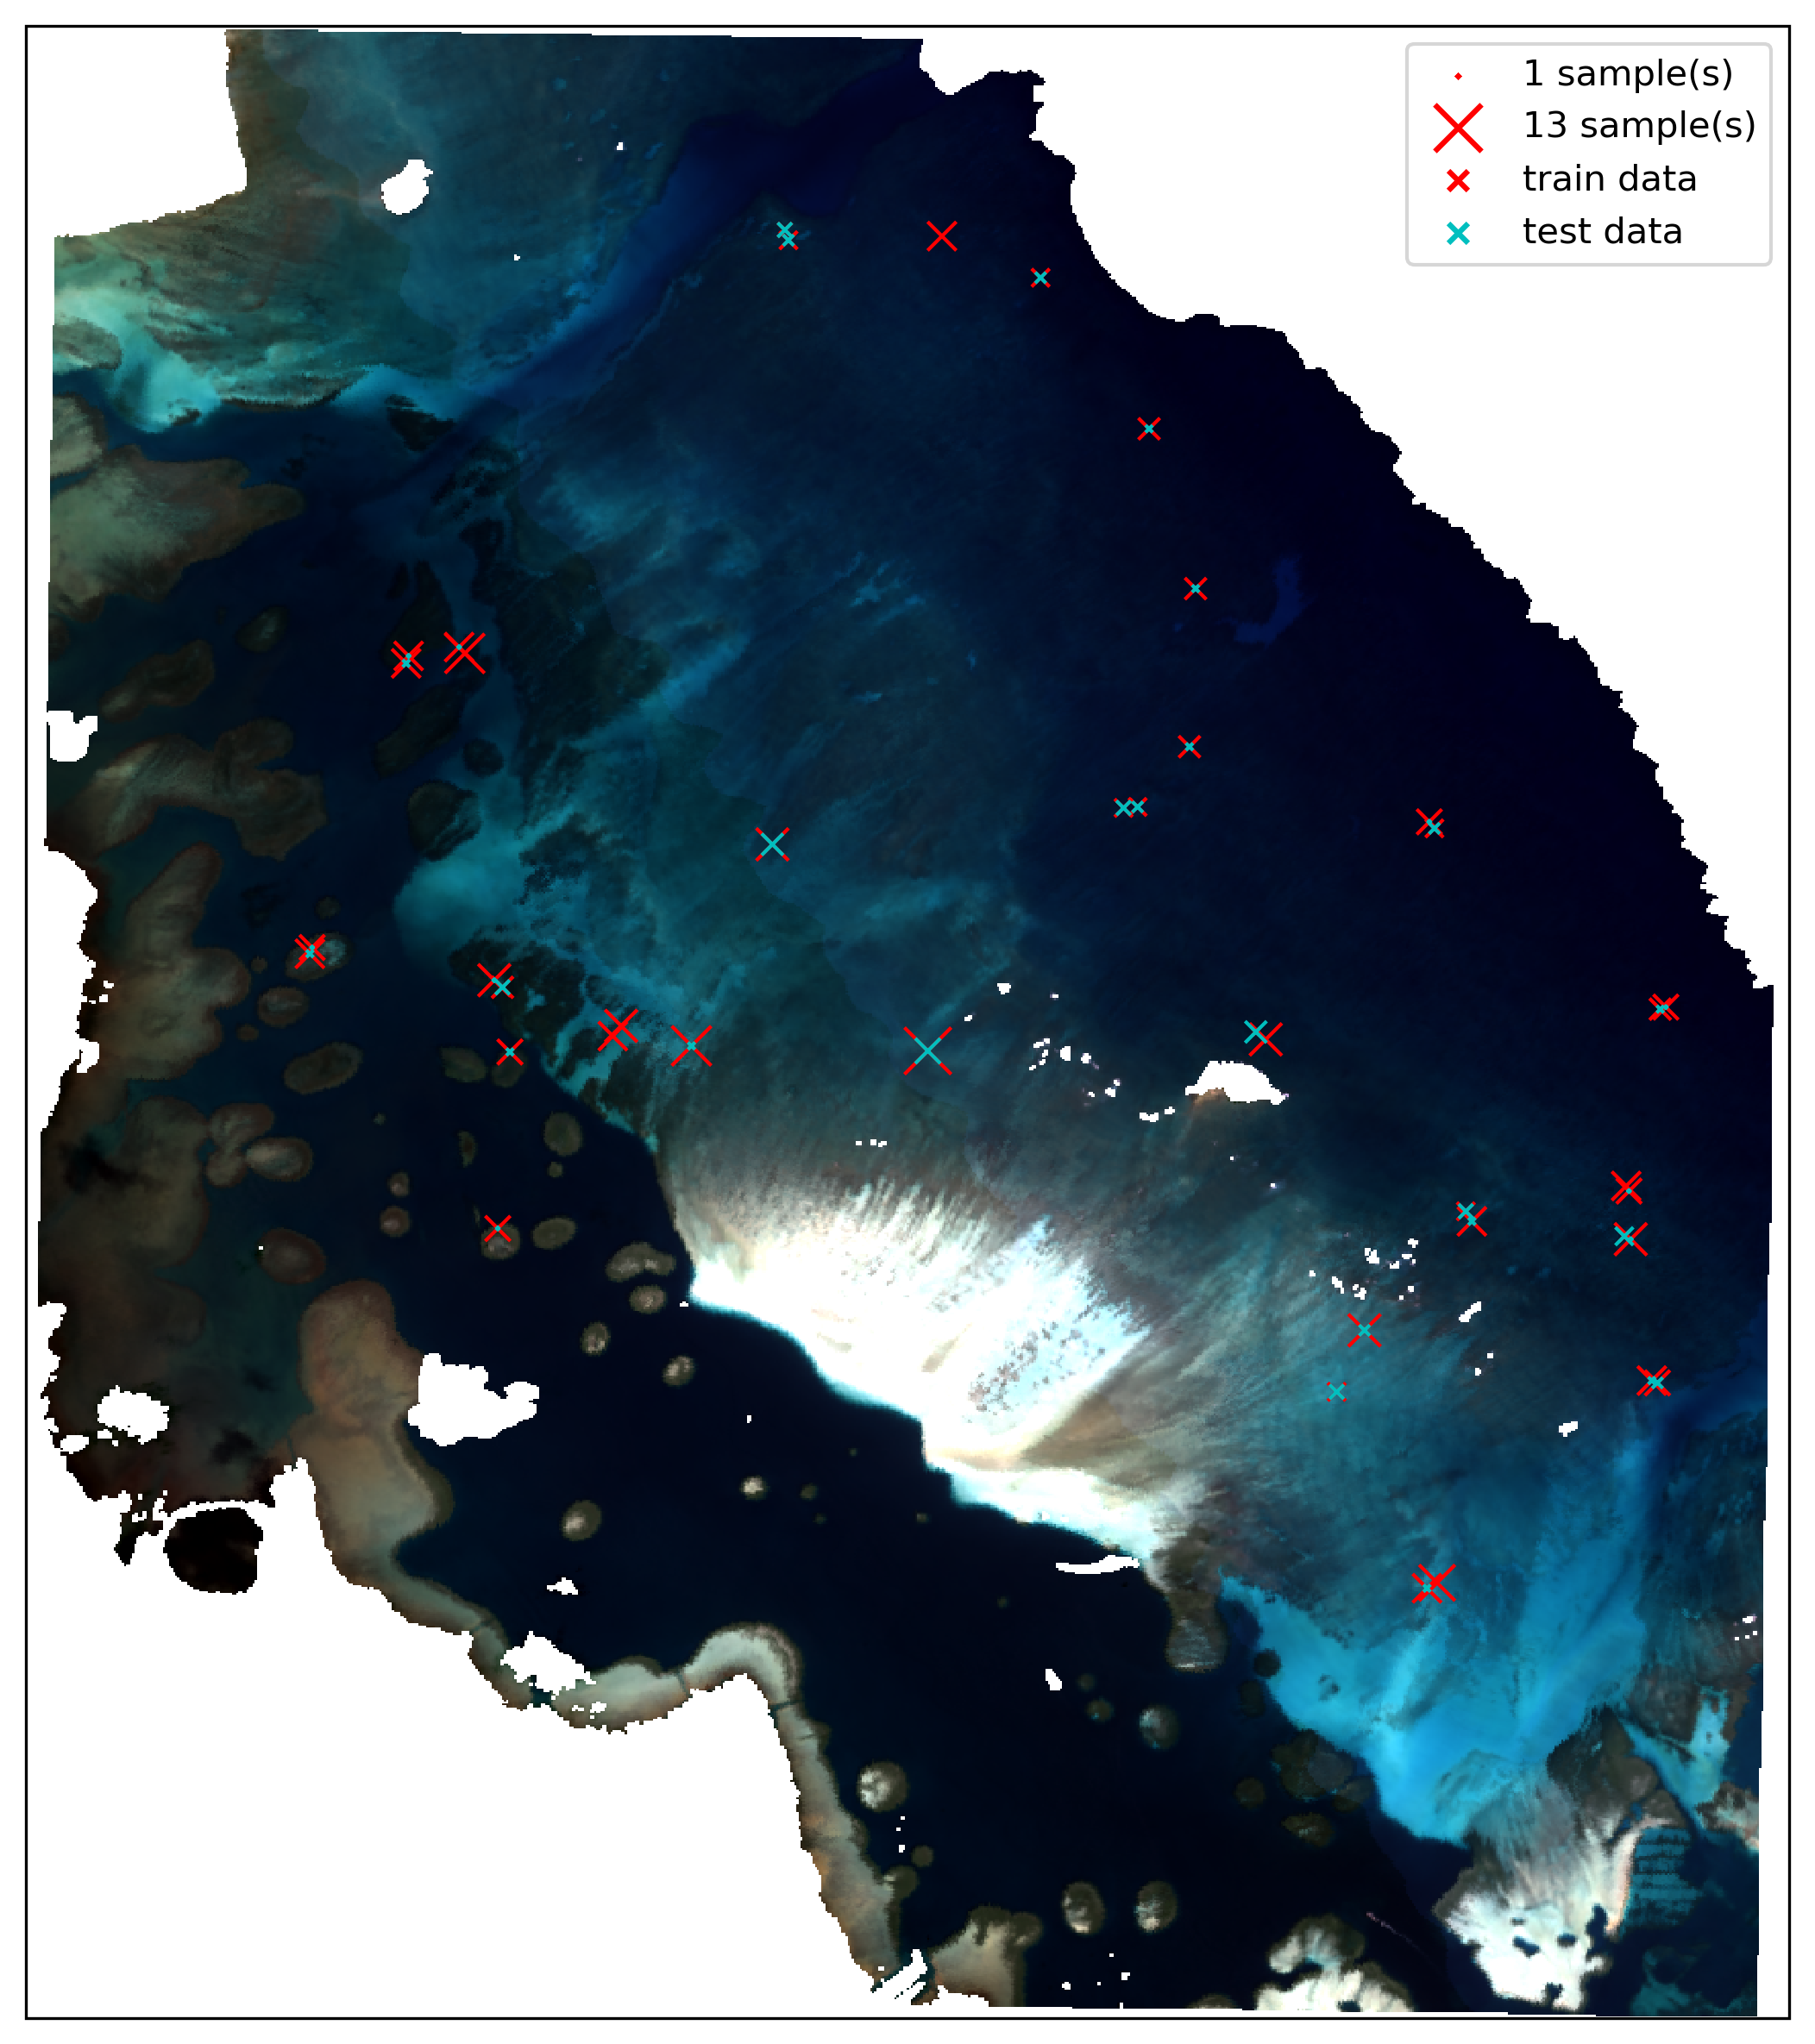

In [45]:
# join labels with validation data
kbay_validation_data = validation_data.loc[kbay_indices].join(kbay_benthic_labels, rsuffix="_label")
kbay_validation_data = kbay_validation_data.loc[kbay_indices].join(kbay_labels, rsuffix="_label")
# kbay_validation_data = validation_data.iloc[kbay_indices]
# select validation data within limits of rgb_xa
kbay_validation_data = kbay_validation_data[(kbay_validation_data.X >= rgb_xa.lon.values.min()) & (kbay_validation_data.X <= rgb_xa.lon.values.max()) & (kbay_validation_data.Y >= rgb_xa.lat.values.min()) & (kbay_validation_data.Y <= rgb_xa.lat.values.max())]

# count the number of samples at each site
train_sample_counts = kbay_train_meta.groupby(['X', 'Y']).size().reset_index(name='counts')
test_sample_counts = kbay_test_meta.groupby(['X', 'Y']).size().reset_index(name='counts')

# plot sites on the prediction map
fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw={"projection": ccrs.PlateCarree()}, dpi=300)
rgb_xa.plot.imshow(rgb="rgb", ax=ax, robust=True)
ax.scatter(train_sample_counts.X, train_sample_counts.Y, s=train_sample_counts.counts ** 2, color="red", marker="x", lw=1, alpha=1)
ax.scatter(test_sample_counts.X, test_sample_counts.Y, s=test_sample_counts.counts ** 2, color="c", marker="x", lw=1, alpha=1)
plt.scatter([],[], marker="x", s=min(min(train_sample_counts.counts), min(test_sample_counts.counts)) ** 2, color="red", label=f"{min(min(train_sample_counts.counts), min(test_sample_counts.counts))} sample(s)")
plt.scatter([],[], marker="x", s=max(max(train_sample_counts.counts), max(test_sample_counts.counts)) ** 2, color="red", label=f"{max(max(train_sample_counts.counts), max(test_sample_counts.counts))} sample(s)")
plt.scatter([],[], marker="x", s=30, color="red", label="train data")
plt.scatter([],[], marker="x", s=30, color="c", label="test data")
plt.legend();

In [109]:
depth_masked_scene = rgb_xa.where(depth_mlp_inferred["depth_pred"] <= 8, np.nan)
fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw={"projection": ccrs.PlateCarree()}, dpi=300)
depth_masked_scene.plot.imshow(rgb="rgb", ax=ax, robust=True);

NameError: name 'depth_mlp_inferred' is not defined

In [39]:
all_predictions_df = masked_endmember_rf_inferred.drop_vars(['spectra', 'band']).to_dataframe()

In [ ]:
kbay_validation_data

In [40]:
import numpy as np

# Verify latitude matching
lat_diff = np.abs(masked_endmember_rf_inferred.lat.values - kbay_validation_data.Y.values[:, np.newaxis])
kbay_validation_data["pixel_y"] = np.argmin(lat_diff, axis=1)

# Verify longitude matching
lon_diff = np.abs(masked_endmember_rf_inferred.lon.values - kbay_validation_data.X.values[:, np.newaxis])
kbay_validation_data["pixel_x"] = np.argmin(lon_diff, axis=1)

np.argmin(lon_diff, axis=1).shape

(395,)

In [41]:
kbay_validation_data.columns

Index(['X', 'Y', 'Campaign', 'Locale', 'Station', 'TimeUTC', 'TimeLocal',
       'Depth', 'Metabolism', 'Optics', 'Comments', 'algCCA', 'algCyano',
       'algMacBrn', 'algMacGrn', 'algMacMix', 'algMacRed', 'algMacUnk',
       'algTurf', 'crlCoral', 'crlBleach', 'othOcto', 'othSeagr', 'othClam',
       'othInvert', 'othOther', 'othSponge', 'othUrchin', 'sedLimest',
       'sedMud', 'sedRubble', 'sedSand', 'ROInumber', 'Flightline', 'algae',
       'coral', 'sand', 'Depth_label', 'pixel_y', 'pixel_x'],
      dtype='object')

In [42]:
algae_preds = []
coral_preds = []
sand_preds = []

for i in range(kbay_validation_data.shape[0]):
    point = endmember_rf_inferred.sel(lat=kbay_validation_data.Y.iloc[i], lon=kbay_validation_data.X.iloc[i], method="nearest")
    algae_preds.append(point.algae_pred.values)
    coral_preds.append(point.coral_pred.values)
    sand_preds.append(point.sand_pred.values)

# plot algae_preds, coral_preds, sand_preds

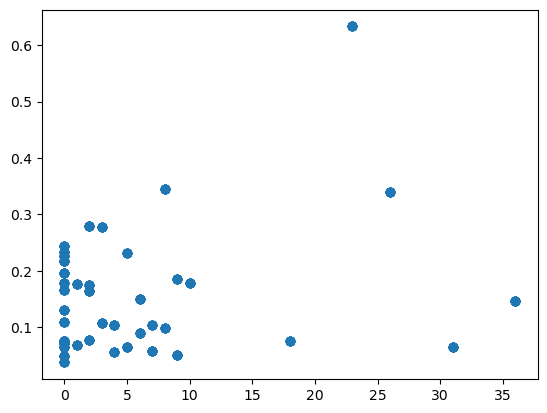

In [44]:
# plt.scatter(kbay_validation_data.algae, algae_preds)
# plt.scatter(kbay_validation_data.coral, coral_preds)
plt.scatter(kbay_validation_data.sand, sand_preds)

21.480649 -157.825682
3.4
inferred depth: 6.559524263094682
labels 0.34 0.35 0.31
predictions 0.5879565217391302 0.37219413549039443 0.06404347826086944


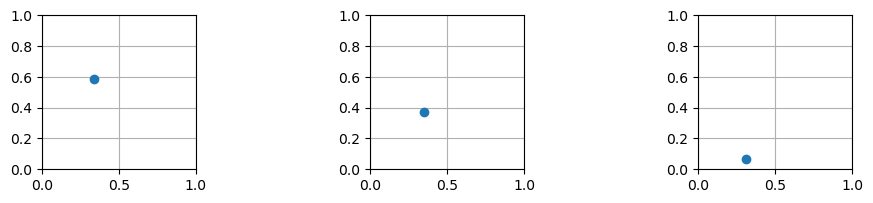

In [46]:
i = 40
# for i in range(len(kbay_validation_data)):
print(kbay_validation_data.Y.iloc[i], kbay_validation_data.X.iloc[i])
algae_label = kbay_validation_data.algae.iloc[i]/100
coral_label = kbay_validation_data.coral.iloc[i]/100
sand_label = kbay_validation_data.sand.iloc[i]/100
print(kbay_validation_data.Depth.iloc[i])
print("inferred depth:", depth_mlp_inferred.sel(lat=kbay_validation_data.Y.iloc[i], lon=kbay_validation_data.X.iloc[i], method="nearest").depth_pred.values)
print("labels", algae_label, coral_label, sand_label)

point = endmember_rf_inferred.sel(lat=kbay_validation_data.Y.iloc[i], lon=kbay_validation_data.X.iloc[i], method="nearest")
algae_pred = point.algae_pred.values
coral_pred = point.coral_pred.values
sand_pred = point.sand_pred.values
print("predictions", algae_pred, coral_pred, sand_pred)

fig, ax = plt.subplots(1,3, figsize=(12, 2))

ax[0].plot(algae_label, algae_pred, 'o')
ax[1].plot(coral_label, coral_pred, 'o')
ax[2].plot(sand_label, sand_pred, 'o')
[a.set_xlim(0, 1) for a in ax];
[a.set_ylim(0, 1) for a in ax];
[a.set_aspect('equal') for a in ax];
[a.grid() for a in ax];

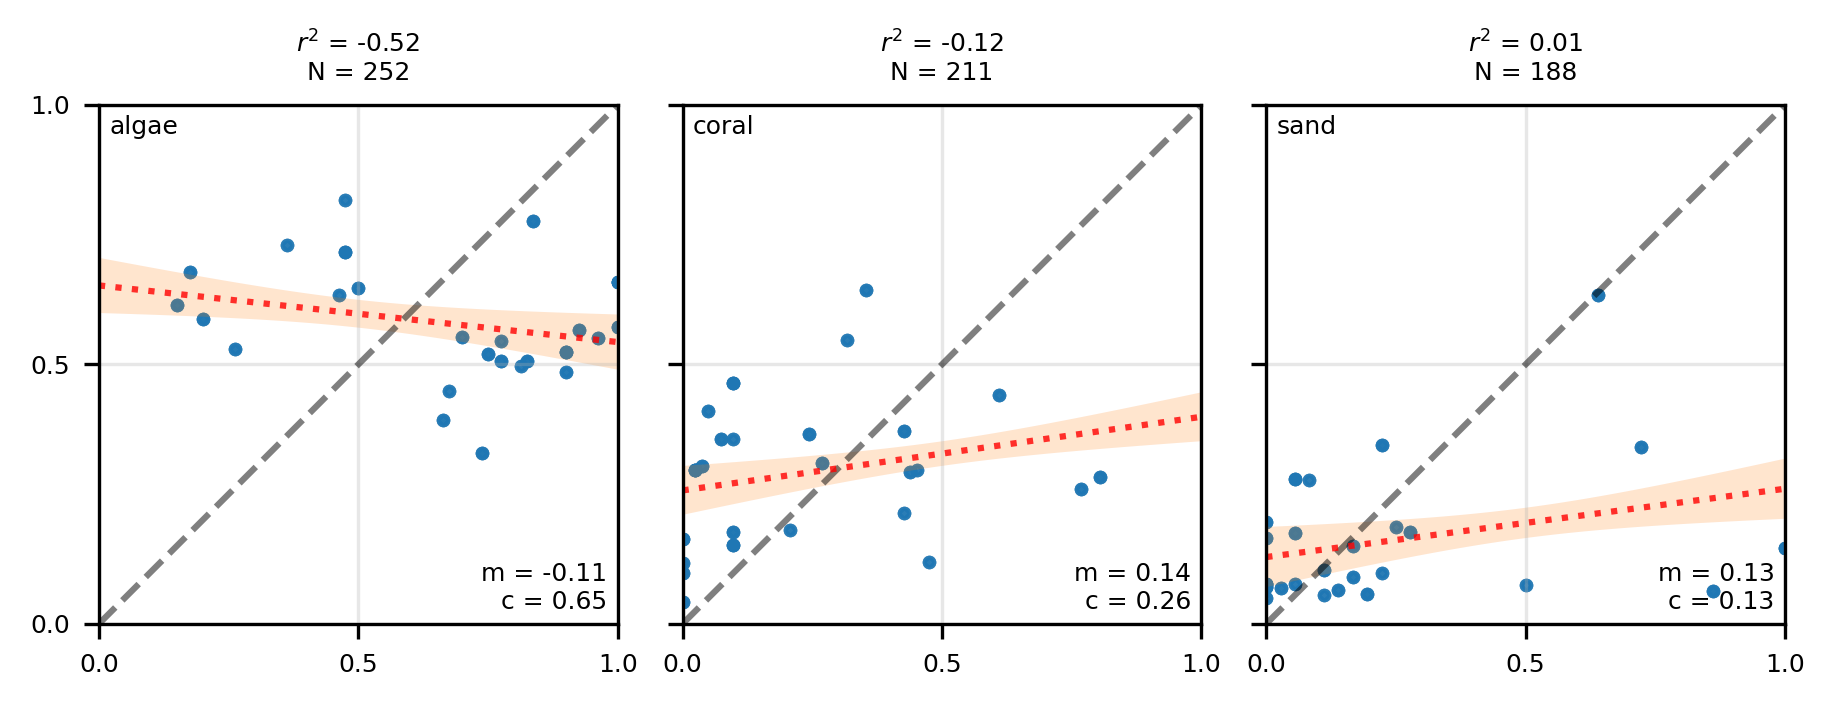

In [47]:
# find the closest pixel to each site in kbay_validation_data
kbay_validation_data["lat"] = kbay_validation_data.Y
kbay_validation_data["lon"] = kbay_validation_data.X
kbay_validation_data["pixel_x"] = np.argmin(np.abs(masked_endmember_rf_inferred.lon.values - kbay_validation_data.X.values[:, np.newaxis]), axis=1)
kbay_validation_data["pixel_y"] = np.argmin(np.abs(masked_endmember_rf_inferred.lat.values - kbay_validation_data.Y.values[:, np.newaxis]), axis=1)
# determine index of prediction from closest pixel
kbay_validation_data["pixel_index"] = kbay_validation_data.pixel_y * masked_endmember_rf_inferred.lon.shape[0] + kbay_validation_data.pixel_x
kbay_validation_data["algae_pred"] = all_predictions_df.values[kbay_validation_data.pixel_index][:,0]
kbay_validation_data["coral_pred"] = all_predictions_df.values[kbay_validation_data.pixel_index][:,1]
kbay_validation_data["sand_pred"] = all_predictions_df.values[kbay_validation_data.pixel_index][:,2]
# add boolean column for train or test data
kbay_validation_data["train-test"] = kbay_validation_data.index.isin(kbay_train_inds)
kbay_validation_data.columns

Index(['X', 'Y', 'Campaign', 'Locale', 'Station', 'TimeUTC', 'TimeLocal',
       'Depth', 'Metabolism', 'Optics', 'Comments', 'algCCA', 'algCyano',
       'algMacBrn', 'algMacGrn', 'algMacMix', 'algMacRed', 'algMacUnk',
       'algTurf', 'crlCoral', 'crlBleach', 'othOcto', 'othSeagr', 'othClam',
       'othInvert', 'othOther', 'othSponge', 'othUrchin', 'sedLimest',
       'sedMud', 'sedRubble', 'sedSand', 'ROInumber', 'Flightline', 'algae',
       'coral', 'sand', 'Depth_label', 'pixel_y', 'pixel_x', 'lat', 'lon',
       'pixel_index', 'algae_pred', 'coral_pred', 'sand_pred', 'train-test'],
      dtype='object')

/Users/rt582/miniforge3/envs/spectra/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


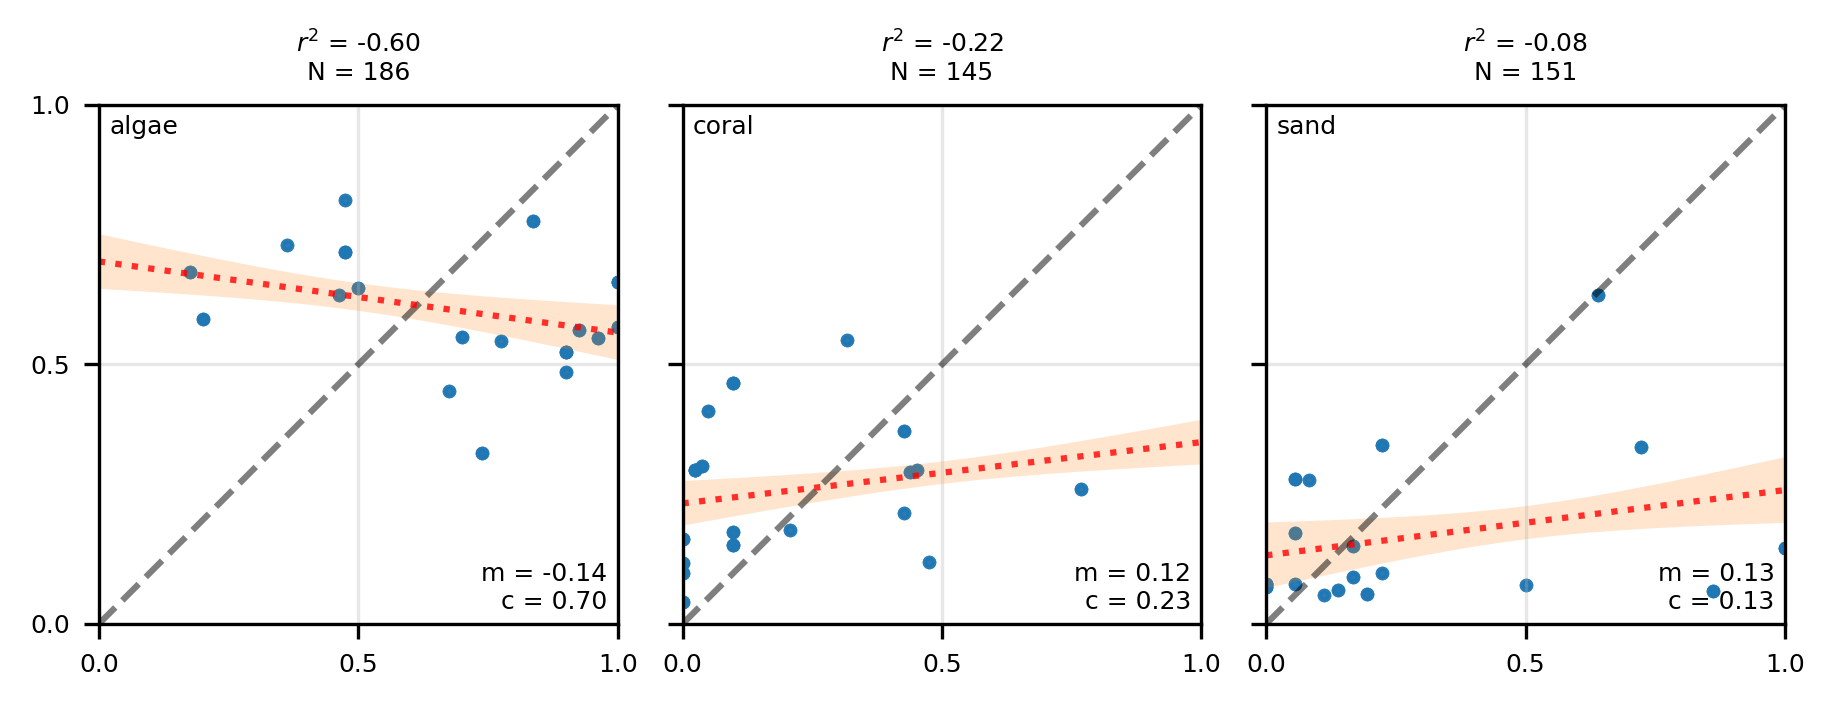

In [48]:
pred_data = kbay_validation_data[["algae_pred", "coral_pred", "sand_pred"]].values
pred_nan_inds = np.isnan(pred_data).any(axis=1)
pred_data = pred_data[~pred_nan_inds]

true_data = kbay_validation_data[["algae", "coral", "sand"]].values[~pred_nan_inds]
# scale true data 
scaler = MinMaxScaler()
scaler = scaler.fit(kbay_validation_data[["algae", "coral", "sand"]].loc[kbay_train_inds])  # scale on train data
test_data = pd.DataFrame(scaler.transform(true_data), columns=["algae", "coral", "sand"])

plotting.plot_regression_results(test_data, pred_data, benthic_labels,
                                #  metadata=kbay_validation_data.loc[pred_nan_inds], color_by="Depth"
                                 )

/Users/rt582/miniforge3/envs/spectra/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


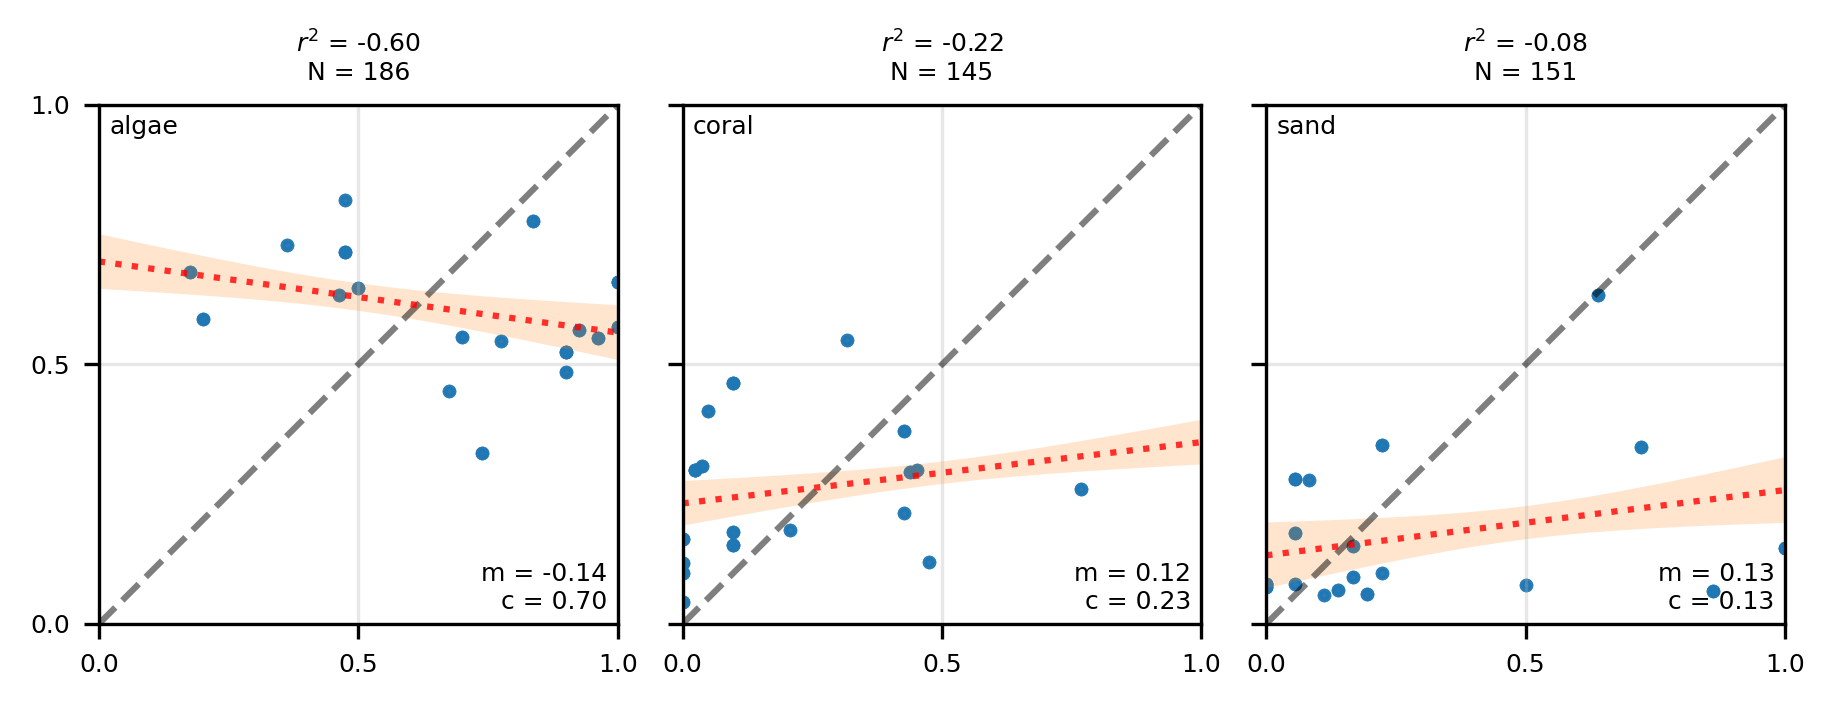

In [49]:

# scaler = scaler.fit(kbay_validation_data[["algae", "coral", "sand"]].loc[kbay_indices.intersection(kbay_validation_data.index)])  # scale on train data
# scale data by train scaler
# test_data = pd.DataFrame(scaler.transform(kbay_validation_data[["algae", "coral", "sand"]]), index=kbay_validation_data.index, columns=["coral", "algae", "sand"])
test_data = pd.DataFrame(scaler.transform(true_data), columns=["algae", "coral", "sand"])
# pred_data = kbay_validation_data[["algae_pred", "coral_pred", "sand_pred"]].values
labels = pd.DataFrame(kbay_validation_data[["algae", "coral", "sand"]], index=kbay_validation_data.index, columns=["algae", "coral", "sand"])


plotting.plot_regression_results(test_data, pred_data, labels,
                                #  metadata=kbay_validation_data.loc[pred_nan_inds], color_by="Depth"
                                 )

In [50]:
# depth predictions

scaler = MinMaxScaler()
scaler = scaler.fit(pd.DataFrame(kbay_validation_data["Depth"].loc[kbay_train_inds]))  # scale on train data
# scale data by train scaler
test_data = pd.DataFrame(scaler.transform(pd.DataFrame(kbay_validation_data["Depth"])), index=kbay_validation_data.index, columns=["Depth"])
pred_data = kbay_validation_data["Depth"].values

In [51]:
test_data

Depth
1151  0.370690
1152  0.370690
1153  0.370690
1154  0.370690
1155  0.318966
...        ...
1559  0.267241
1560  0.344828
1561  0.344828
1562  0.344828
1563  0.344828

[395 rows x 1 columns]

In [110]:
# scale ["coral", "algae", "sand"] columns in kbay_validation_data
# kbay_validation_data[["coral", "algae", "sand"]] = scaler.transform(kbay_validation_data[["coral", "algae", "sand"]])

train_results = kbay_validation_data[kbay_validation_data["train-test"] == True]
test_results = kbay_validation_data[kbay_validation_data["train-test"] == False]
train_results_true = train_results[["coral", "algae", "sand"]]
train_results_pred = train_results[["coral_pred", "algae_pred", "sand_pred"]]
test_results_true = test_results[["coral", "algae", "sand"]]
test_results_pred = test_results[["coral_pred", "algae_pred", "sand_pred"]]

KeyError: 'train-test'

In [ ]:
plt.figure(figsize=(5, 5))
plt.scatter(train_results_true, train_results_pred, color="r", label="Train Data", alpha=0.5, s=5)
plt.scatter(test_results_true, test_results_pred, color="c", label="Test Data", alpha=0.5, s=5)
plt.plot([0, 1], [0, 1], color="k", lw=1, ls="--")
plt.axis("equal")
plt.xlim(0, 1)
plt.ylim(0, 1)

# r2_score(test_results_true, test_results_pred)

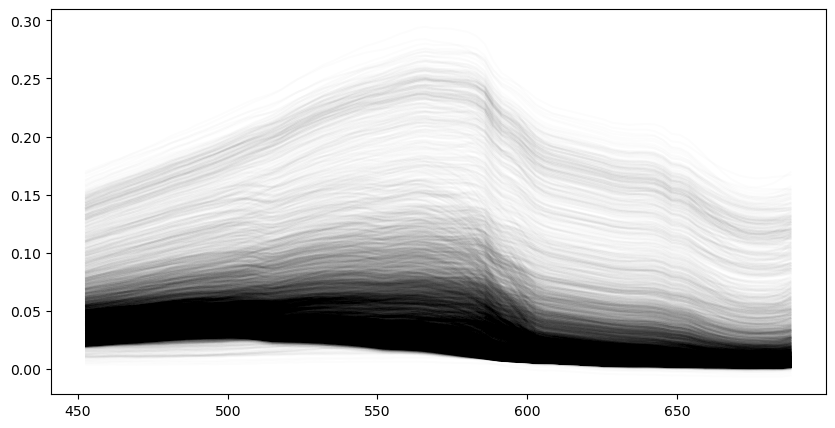

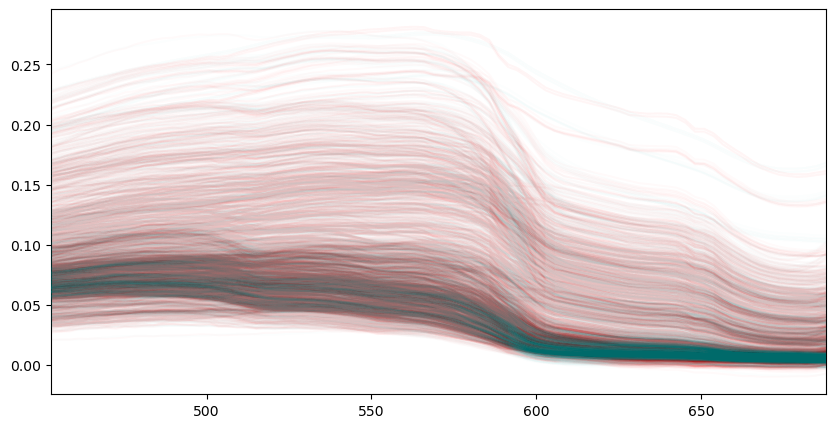

In [3]:
# compare spectra
prism_spectra = spectrum_utils.preprocess_prism_spectra(spectrum_utils.load_spectra())
fit_fp = "/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/coralreflections/results/fits/fit_results_1.csv"
fits = pd.read_csv(fit_fp, header=[0,1])
fits = fits.fitted_spectra
fits.columns = fits.columns.astype(float)

scene_xa = xa.open_dataset(file_ops.KANEOHE_HS_FP).site
masked_scene_vals = scene_xa.values.reshape(scene_xa.sizes["band"], -1)

wvs = scene_xa.band.values
hs_vals = pd.DataFrame(masked_scene_vals.T, columns=wvs)
# process: deglint and crop to sensor range
hs_vals = spectrum_utils.deglint_spectra(hs_vals)
hs_vals = spectrum_utils.crop_spectra_to_range(hs_vals)
no_nan_hs_vals = hs_vals.dropna()


plt.figure(figsize=(10, 5))
plt.plot(no_nan_hs_vals[::100].T, c="k", alpha=0.01);
plt.figure(figsize=(10, 5))
plt.plot(prism_spectra.T, c="r", alpha=0.02);
plt.plot(fits.T, c="c", alpha=0.01, zorder=10);
plt.xlim(prism_spectra.columns.min(), prism_spectra.columns.max());

In [113]:
N = -1
spectra_source1 = no_nan_hs_vals.iloc[:N,:]
spectra_source2 = prism_spectra.iloc[:N,:]
spectra_source3 = fits.iloc[:N,:]
spectra_source2.shape[1]

84

In [118]:
# statistically compare two batches of spectra

p_values = np.zeros(spectra_source1.shape[1])
for i in range(spectra_source1.shape[1]):
    stat, p_val = ks_2samp(spectra_source3.iloc[:, i], spectra_source2.iloc[:, i])
    p_values[i] = p_val
    
# p_values

In [120]:
# pca both distributions

pca1 = PCA(n_components=1)
pca1.fit(spectra_source3)
pca_source1 = pca1.transform(spectra_source3)
pca2 = PCA(n_components=1)
pca2.fit(spectra_source2)
pca_source2 = pca2.transform(spectra_source2)

# statistically compare pca components
stat, p_val = ks_2samp(pca_source1, pca_source2)
print(stat, p_val)

[0.00206505] [1.]


In [116]:
ks_2samp(pca_source1, pca_source2)

KstestResult(statistic=array([0.]), pvalue=array([1.]), statistic_location=array([-0.6594409]), statistic_sign=array([1.]))

In [117]:

# Combine data from both sources and add a label
data = np.vstack([spectra_source1.values, spectra_source2.values])
labels = np.array([0]*spectra_source1.shape[0] + [1]*spectra_source2.shape[0])

# Perform MANOVA (multivariate analysis of variance)
manova = MANOVA(endog=data, exog=labels)
print(manova.mv_test())


                     Multivariate linear model
                                                                   
-------------------------------------------------------------------
           x0           Value   Num DF    Den DF    F Value  Pr > F
-------------------------------------------------------------------
          Wilks' lambda 0.7482 84.0000 688510.0000 2758.6704 0.0000
         Pillai's trace 0.2518 84.0000 688510.0000 2758.6704 0.0000
 Hotelling-Lawley trace 0.3366 84.0000 688510.0000 2758.6704 0.0000
    Roy's greatest root 0.3366 84.0000 688510.0000 2758.6704 0.0000



- Predict depth and compare with LIDAR
- Use depth as a parameter